In [5]:
from glob import glob
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import3train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import Pipeline


In [2]:
files = glob("Alshutairi/*.txt")
dataframes = []

for file in files:
    region = file[-7:-4]
    temp_df = pd.read_csv(file, encoding="utf8", delimiter="\n", names=["Text"])
    temp_df["Region"] = region
    dataframes.append(temp_df)
    
df = pd.concat(dataframes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df["Text"], df["Region"], random_state=0)
count_vectorizer = CountVectorizer().fit(X_train)
X_train_vectorized = count_vectorizer.transform(X_train)
X_test_vectorized = count_vectorizer.transform(X_test)

In [ ]:
naive_bayes = MultinomialNB(alpha=0.1)
naive_bayes.fit(X_train_vectorized, y_train)
naive_bayes.score(X_test_vectorized, y_test)

In [ ]:
"""
https://github.com/bakrianoo/aravec/blob/master/utilities.py
"""

# =========================
# ==== Helper Methods =====
import re
import numpy as np
from nltk import ngrams

# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

def get_vec(n_model,dim, token):
    vec = np.zeros(dim)
    is_vec = False
    if token not in n_model.wv:
        _count = 0
        is_vec = True
        for w in token.split("_"):
            if w in n_model.wv:
                _count += 1
                vec += n_model.wv[w]
        if _count > 0:
            vec = vec / _count
    else:
        vec = n_model.wv[token]
    return vec

def calc_vec(pos_tokens, neg_tokens, n_model, dim):
    vec = np.zeros(dim)
    for p in pos_tokens:
        vec += get_vec(n_model,dim,p)
    for n in neg_tokens:
        vec -= get_vec(n_model,dim,n)
    
    return vec   

## -- Retrieve all ngrams for a text in between a specific range
def get_all_ngrams(text, nrange=3):
    text = re.sub(r'[\,\.\;\(\)\[\]\_\+\#\@\!\?\؟\^]', ' ', text)
    tokens = [token for token in text.split(" ") if token.strip() != ""]
    ngs = []
    for n in range(2,nrange+1):
        ngs += [ng for ng in ngrams(tokens, n)]
    return ["_".join(ng) for ng in ngs if len(ng)>0 ]

## -- Retrieve all ngrams for a text in a specific n
def get_ngrams(text, n=2):
    text = re.sub(r'[\,\.\;\(\)\[\]\_\+\#\@\!\?\؟\^]', ' ', text)
    tokens = [token for token in text.split(" ") if token.strip() != ""]
    ngs = [ng for ng in ngrams(tokens, n)]
    return ["_".join(ng) for ng in ngs if len(ng)>0 ]

## -- filter the existed tokens in a specific model
def get_existed_tokens(tokens, n_model):
    return [tok for tok in tokens if tok in n_model.wv ]

In [ ]:
import gensim
import re
import numpy as np
from nltk import ngrams

t_model = gensim.models.Word2Vec.load('models/full_grams_cbow_300_twitter.mdl')

In [ ]:
t_model.wv.most_similar("سعودي", topn=10)

In [ ]:
def word2vectorize(tokens):
    res = []
    for i, token in enumerate(tokens):
        if i % 100000 == 0:
            print(f"Finished {i}/{len(tokens)}")
        res.append(calc_vec(pos_tokens=token.split(), neg_tokens=[], n_model=t_model, dim=t_model.vector_size))
    return np.array(res)

X_train_word2vectorized = word2vectorize(X_train)
X_test_word2vectorized = word2vectorize(X_test)

In [ ]:
naive_bayes2 = MultinomialNB(alpha=0.1)
naive_bayes2.fit(X_train_word2vectorized, y_train)
naive_bayes2.score(X_test_word2vectorized, y_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
logisticRegressor = LogisticRegression(random_state=0).fit(X_train_word2vectorized, y_train)
logisticRegressor.score(X_test_word2vectorized, y_test)

In [ ]:
from sklearn.svm import LinearSVC
svc = LinearSVC(random_state=0).fit(X_train_word2vectorized, y_train)
svc.score(X_test_word2vectorized, y_test)


## Section 2

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
from glob import glob
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from torchvision.utils import make_grid

In [2]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

dataset = torchvision.datasets.CelebA("images", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=8,
                                          shuffle=True, num_workers=2)

In [3]:
img_iter = iter(trainloader)

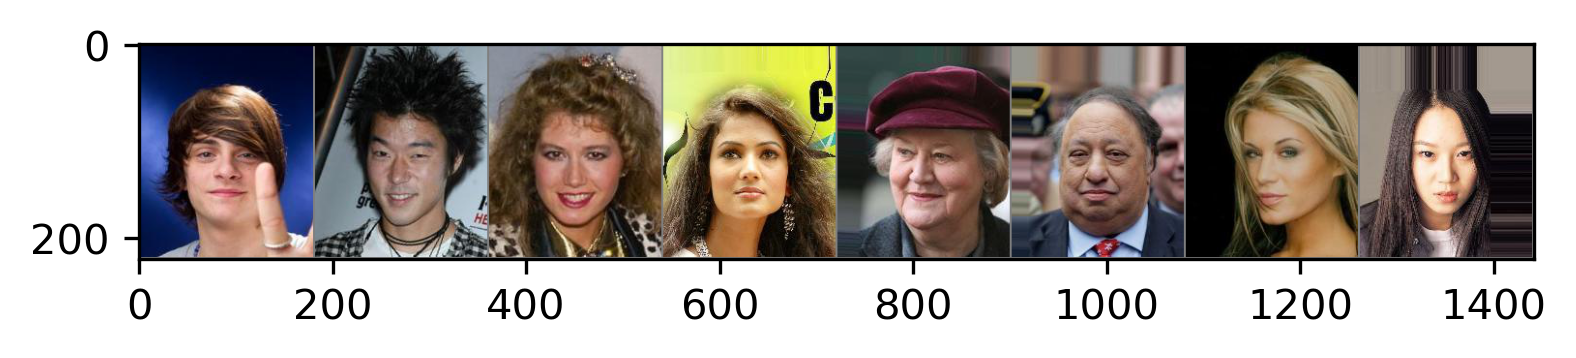

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

def imshow(img):
    img = img / 2 + 0.5
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)), )
    plt.show()
    
images, label = img_iter.next()
imshow(torchvision.utils.make_grid(images, scale_each=True))

# CONV2D & MAXPOOL2D: 
```out = (in + 2 * padding - dilation * (kernel - 1) - 1)/stride + 1```
## CONVTRANSPOSE2D: 
```out = (in - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1```

_____________________
Note: floor result <br>
Note: image size (218, 178)

In [80]:
from torch import nn 
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 9, 3, padding=1), # 218, 178
            nn.ReLU(),
            nn.Conv2d(9, 18, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1), # 110, 90
            
            nn.Conv2d(18, 27, 3, padding=1), # 110, 90
            nn.ReLU(),
            nn.Conv2d(27, 36, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),  # 56, 46
            
            nn.Conv2d(36, 45, 3, padding=1), # 56, 46
            nn.ReLU(),
            nn.Conv2d(45, 54, 3, padding=1), # 56, 46
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),  # 29, 24
            
            nn.Conv2d(54, 63, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(63, 72, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1, ceil_mode=True),  # 15, 13
            
            nn.Conv2d(72, 81, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(81, 90, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),  # 8, 7
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(90, 81, 3, stride=2, padding=1), # 15, 13
            nn.ReLU(),
            nn.ConvTranspose2d(81, 72, 3, padding=1), 
            nn.ReLU(),
            
            nn.ConvTranspose2d(72, 63, 3, stride=2, padding=(1, 2), output_padding=(0, 1)), # 29, 24
            nn.ReLU(),
            nn.ConvTranspose2d(63, 54, 3, padding=1), 
            nn.ReLU(),
            
            nn.ConvTranspose2d(54, 45, 2, stride=2, padding=1), # 56, 46
            nn.ReLU(),
            nn.ConvTranspose2d(45, 36, 3, padding=1), # 56, 46
            nn.ReLU(),
            
            nn.ConvTranspose2d(36, 27, 2, stride=2, padding=1), # 110, 90
            nn.ReLU(),
            nn.ConvTranspose2d(27, 18, 3, padding=1), # 110, 90
            nn.ReLU(),
            
            nn.ConvTranspose2d(18, 9, 2, stride=2, padding=1), # 218, 178
            nn.ReLU(),
            nn.ConvTranspose2d(9, 3, 3, padding=1), # 218, 178
#             nn.Tanh()
            nn.Conv2d(3, 9, 3, padding=1), # 218, 178
            nn.ReLU(),
            nn.Conv2d(9, 18, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1), # 110, 90
            
            nn.Conv2d(18, 27, 3, padding=1), # 110, 90
            nn.ReLU(),
            nn.Conv2d(27, 36, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),  # 56, 46
            
            nn.Conv2d(36, 45, 3, padding=1), # 56, 46
            nn.ReLU(),
            nn.Conv2d(45, 54, 3, padding=1), # 56, 46
            nn.ReLU(),
            nn.MaxPool2d(2, padding=1),  # 29, 24
            
            nn.Conv2d(54, 63, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(63, 72, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1, ceil_mode=True),  # 15, 13
            
            nn.Conv2d(72, 81, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(81, 90, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2, padding=1),  # 8, 7
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(90, 81, 3, stride=2, padding=1), # 15, 13
            nn.ReLU(),
            nn.ConvTranspose2d(81, 72, 3, padding=1), 
            nn.ReLU(),
            
            nn.ConvTranspose2d(72, 63, 3, stride=2, padding=(1, 2), output_padding=(0, 1)), # 29, 24
            nn.ReLU(),
            nn.ConvTranspose2d(63, 54, 3, padding=1), 
            nn.ReLU(),
            
            nn.ConvTranspose2d(54, 45, 2, stride=2, padding=1), # 56, 46
            nn.ReLU(),
            nn.ConvTranspose2d(45, 36, 3, padding=1), # 56, 46
            nn.ReLU(),
            
            nn.ConvTranspose2d(36, 27, 2, stride=2, padding=1), # 110, 90
            nn.ReLU(),
            nn.ConvTranspose2d(27, 18, 3, padding=1), # 110, 90
            nn.ReLU(),
            
            nn.ConvTranspose2d(18, 9, 2, stride=2, padding=1), # 218, 178
            nn.ReLU(),
            nn.ConvTranspose2d(9, 3, 3, padding=1), # 218, 178
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = AutoEncoder().cuda()

In [81]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)
# .Adam(model.parameters(), lr=0.01,
#                              weight_decay=1e-5)

history = []
num_epochs = 1000
for epoch in range(num_epochs):
    overall_loss = 0
    for data in trainloader:
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        overall_loss += loss.detach().item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, overall_loss / len(trainloader)))
    history.append(output.cpu().data)
        

epoch [1/1000], loss:0.0508
epoch [2/1000], loss:0.0330
epoch [3/1000], loss:0.0302
epoch [4/1000], loss:0.0285
epoch [5/1000], loss:0.0273
epoch [6/1000], loss:0.0263
epoch [7/1000], loss:0.0255
epoch [8/1000], loss:0.0248
epoch [9/1000], loss:0.0241
epoch [10/1000], loss:0.0235
epoch [11/1000], loss:0.0230
epoch [12/1000], loss:0.0225
epoch [13/1000], loss:0.0221
epoch [14/1000], loss:0.0218
epoch [15/1000], loss:0.0215
epoch [16/1000], loss:0.0211
epoch [17/1000], loss:0.0209
epoch [18/1000], loss:0.0206
epoch [19/1000], loss:0.0203
epoch [20/1000], loss:0.0200
epoch [21/1000], loss:0.0196
epoch [22/1000], loss:0.0192
epoch [23/1000], loss:0.0189
epoch [24/1000], loss:0.0187
epoch [25/1000], loss:0.0185
epoch [26/1000], loss:0.0183
epoch [27/1000], loss:0.0182
epoch [28/1000], loss:0.0180
epoch [29/1000], loss:0.0179
epoch [30/1000], loss:0.0177
epoch [31/1000], loss:0.0176
epoch [32/1000], loss:0.0175
epoch [33/1000], loss:0.0174
epoch [34/1000], loss:0.0173
epoch [35/1000], loss:0

KeyboardInterrupt: 

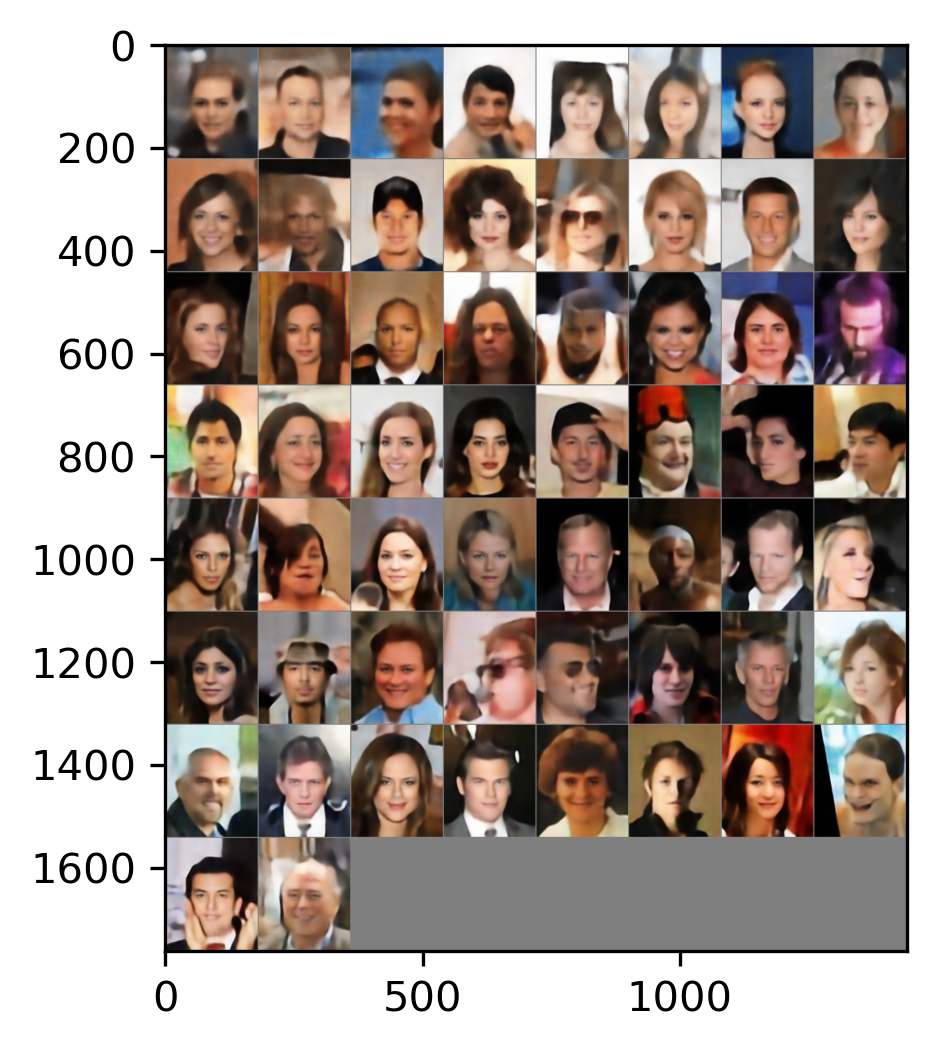

In [82]:
cpu_images = [img.cpu().data[0] for img in history]
imshow(torchvision.utils.make_grid(cpu_images, scale_each=True))

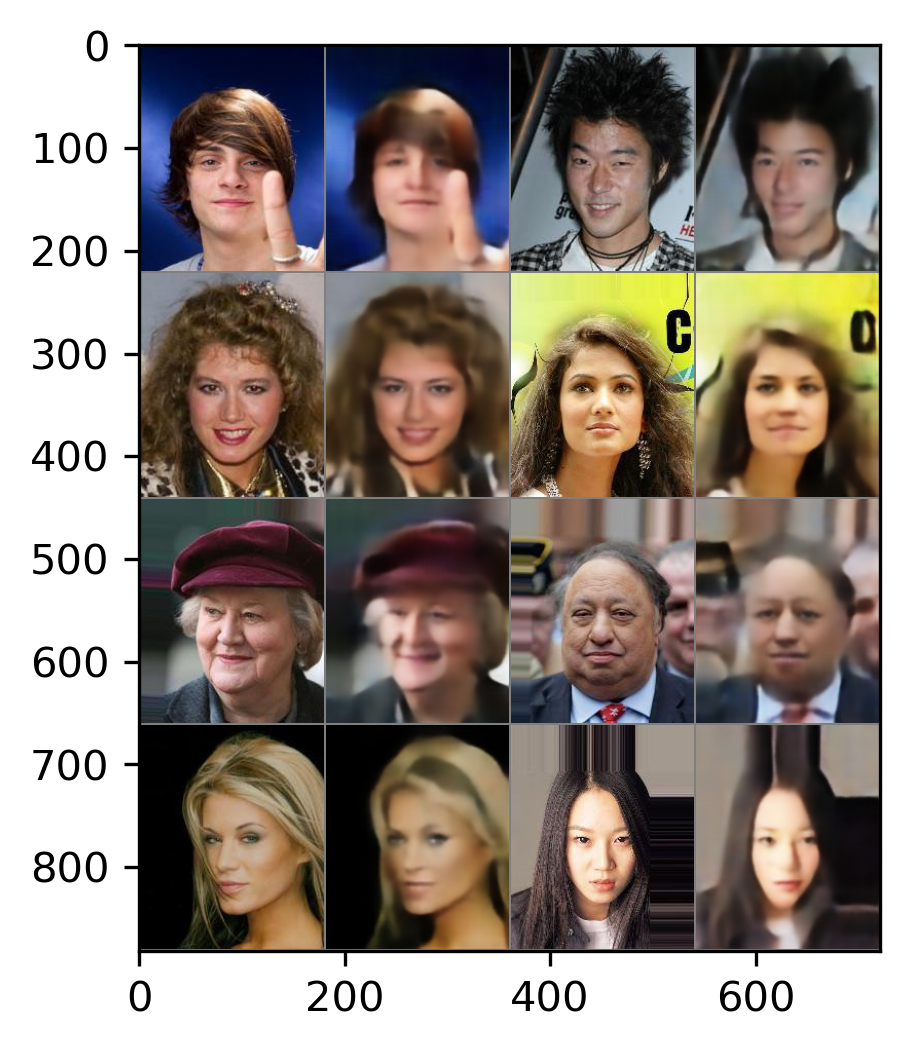

In [83]:
comparison = []
for m in images:
    comparison.append(m)
    comparison.append(model(torch.unsqueeze(m, 0).cuda())[0].detach().cpu())
original = images[1]
test = torch.unsqueeze(original, 0).cuda()
imshow(make_grid(comparison, nrow=4))

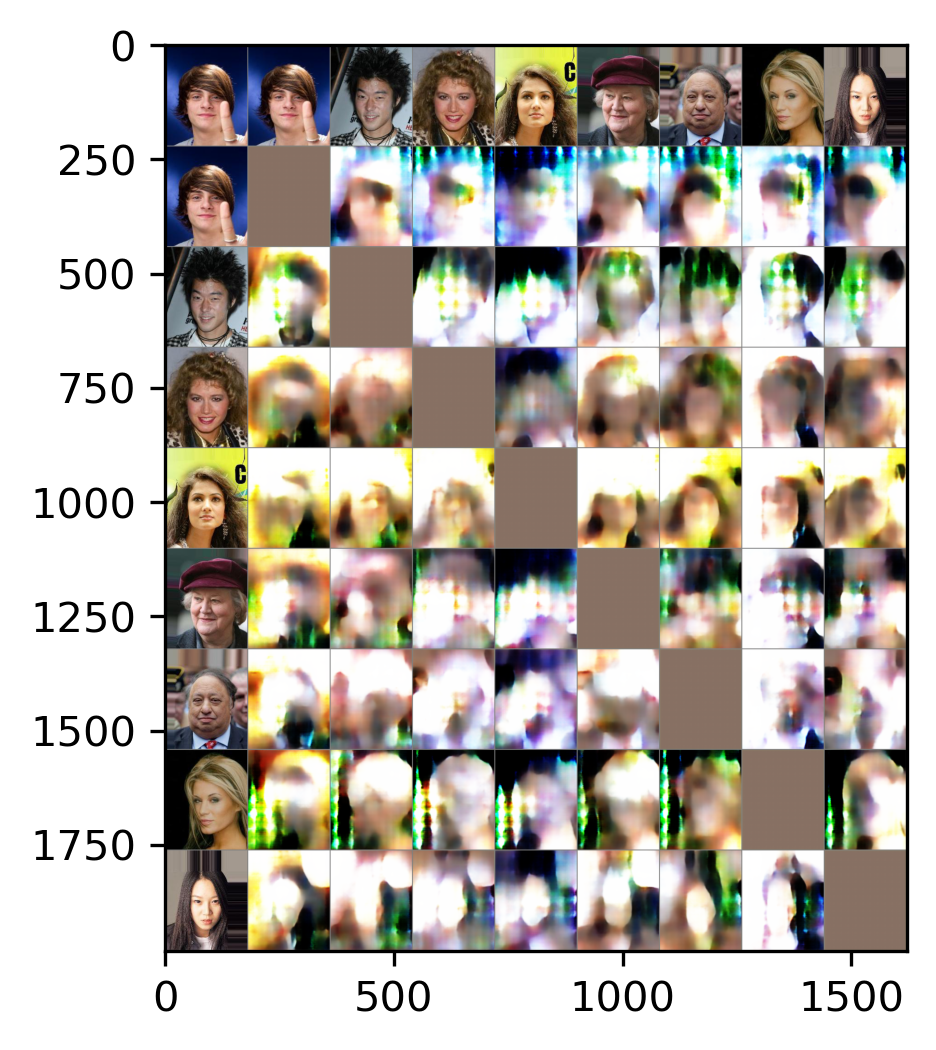

In [84]:
comparison2 = [torch.cat((torch.unsqueeze(images[0], 0), images), 0)]
for m in images:
    temp = [m]
    mg = torch.unsqueeze(m, 0).cuda()
    for m2 in images:
        mg2 = torch.unsqueeze(m2, 0).cuda()
        temp.append(model.decoder(model.encoder(mg) - model.encoder(mg2)).detach().cpu()[0])
    comparison2.append(torch.stack(temp))

comparison2 = torch.stack(comparison2)    
imshow(make_grid(torch.flatten(comparison2, end_dim=1), nrow=9))

In [21]:
def removeDuplicates(nums) -> int:        
    for i in range(len(nums)-1, 0, -1):
        if nums[i] == nums[i-1]:
            nums.pop(i)

    return len(nums)

In [22]:
removeDuplicates([1, 1, 2])

2

In [11]:
nums = [-999,-999,-998,-998,-997,-997,-996,-996,-995,-995,-994,-994,-993,-993,-992,-992,-991,-991,-990,-990,-989,-989,-988,-988,-987,-987,-986,-986,-985,-985,-984,-984,-983,-983,-982,-982,-981,-981,-980,-980,-979,-979,-978,-978,-977,-977,-976,-976,-975,-975,-974,-974,-973,-973,-972,-972,-971,-971,-970,-970,-969,-969,-968,-968,-967,-967,-966,-966,-965,-965,-964,-964,-963,-963,-962,-962,-961,-961,-960,-960,-959,-959,-958,-958,-957,-957,-956,-956,-955,-955,-954,-954,-953,-953,-952,-952,-951,-951,-950,-950,-949,-949,-948,-948,-947,-947,-946,-946,-945,-945,-944,-944,-943,-943,-942,-942,-941,-941,-940,-940,-939,-939,-938,-938,-937,-937,-936,-936,-935,-935,-934,-934,-933,-933,-932,-932,-931,-931,-930,-930,-929,-929,-928,-928,-927,-927,-926,-926,-925,-925,-924,-924,-923,-923,-922,-922,-921,-921,-920,-920,-919,-919,-918,-918,-917,-917,-916,-916,-915,-915,-914,-914,-913,-913,-912,-912,-911,-911,-910,-910,-909,-909,-908,-908,-907,-907,-906,-906,-905,-905,-904,-904,-903,-903,-902,-902,-901,-901,-900,-900,-899,-899,-898,-898,-897,-897,-896,-896,-895,-895,-894,-894,-893,-893,-892,-892,-891,-891,-890,-890,-889,-889,-888,-888,-887,-887,-886,-886,-885,-885,-884,-884,-883,-883,-882,-882,-881,-881,-880,-880,-879,-879,-878,-878,-877,-877,-876,-876,-875,-875,-874,-874,-873,-873,-872,-872,-871,-871,-870,-870,-869,-869,-868,-868,-867,-867,-866,-866,-865,-865,-864,-864,-863,-863,-862,-862,-861,-861,-860,-860,-859,-859,-858,-858,-857,-857,-856,-856,-855,-855,-854,-854,-853,-853,-852,-852,-851,-851,-850,-850,-849,-849,-848,-848,-847,-847,-846,-846,-845,-845,-844,-844,-843,-843,-842,-842,-841,-841,-840,-840,-839,-839,-838,-838,-837,-837,-836,-836,-835,-835,-834,-834,-833,-833,-832,-832,-831,-831,-830,-830,-829,-829,-828,-828,-827,-827,-826,-826,-825,-825,-824,-824,-823,-823,-822,-822,-821,-821,-820,-820,-819,-819,-818,-818,-817,-817,-816,-816,-815,-815,-814,-814,-813,-813,-812,-812,-811,-811,-810,-810,-809,-809,-808,-808,-807,-807,-806,-806,-805,-805,-804,-804,-803,-803,-802,-802,-801,-801,-800,-800,-799,-799,-798,-798,-797,-797,-796,-796,-795,-795,-794,-794,-793,-793,-792,-792,-791,-791,-790,-790,-789,-789,-788,-788,-787,-787,-786,-786,-785,-785,-784,-784,-783,-783,-782,-782,-781,-781,-780,-780,-779,-779,-778,-778,-777,-777,-776,-776,-775,-775,-774,-774,-773,-773,-772,-772,-771,-771,-770,-770,-769,-769,-768,-768,-767,-767,-766,-766,-765,-765,-764,-764,-763,-763,-762,-762,-761,-761,-760,-760,-759,-759,-758,-758,-757,-757,-756,-756,-755,-755,-754,-754,-753,-753,-752,-752,-751,-751,-750,-750,-749,-749,-748,-748,-747,-747,-746,-746,-745,-745,-744,-744,-743,-743,-742,-742,-741,-741,-740,-740,-739,-739,-738,-738,-737,-737,-736,-736,-735,-735,-734,-734,-733,-733,-732,-732,-731,-731,-730,-730,-729,-729,-728,-728,-727,-727,-726,-726,-725,-725,-724,-724,-723,-723,-722,-722,-721,-721,-720,-720,-719,-719,-718,-718,-717,-717,-716,-716,-715,-715,-714,-714,-713,-713,-712,-712,-711,-711,-710,-710,-709,-709,-708,-708,-707,-707,-706,-706,-705,-705,-704,-704,-703,-703,-702,-702,-701,-701,-700,-700,-699,-699,-698,-698,-697,-697,-696,-696,-695,-695,-694,-694,-693,-693,-692,-692,-691,-691,-690,-690,-689,-689,-688,-688,-687,-687,-686,-686,-685,-685,-684,-684,-683,-683,-682,-682,-681,-681,-680,-680,-679,-679,-678,-678,-677,-677,-676,-676,-675,-675,-674,-674,-673,-673,-672,-672,-671,-671,-670,-670,-669,-669,-668,-668,-667,-667,-666,-666,-665,-665,-664,-664,-663,-663,-662,-662,-661,-661,-660,-660,-659,-659,-658,-658,-657,-657,-656,-656,-655,-655,-654,-654,-653,-653,-652,-652,-651,-651,-650,-650,-649,-649,-648,-648,-647,-647,-646,-646,-645,-645,-644,-644,-643,-643,-642,-642,-641,-641,-640,-640,-639,-639,-638,-638,-637,-637,-636,-636,-635,-635,-634,-634,-633,-633,-632,-632,-631,-631,-630,-630,-629,-629,-628,-628,-627,-627,-626,-626,-625,-625,-624,-624,-623,-623,-622,-622,-621,-621,-620,-620,-619,-619,-618,-618,-617,-617,-616,-616,-615,-615,-614,-614,-613,-613,-612,-612,-611,-611,-610,-610,-609,-609,-608,-608,-607,-607,-606,-606,-605,-605,-604,-604,-603,-603,-602,-602,-601,-601,-600,-600,-599,-599,-598,-598,-597,-597,-596,-596,-595,-595,-594,-594,-593,-593,-592,-592,-591,-591,-590,-590,-589,-589,-588,-588,-587,-587,-586,-586,-585,-585,-584,-584,-583,-583,-582,-582,-581,-581,-580,-580,-579,-579,-578,-578,-577,-577,-576,-576,-575,-575,-574,-574,-573,-573,-572,-572,-571,-571,-570,-570,-569,-569,-568,-568,-567,-567,-566,-566,-565,-565,-564,-564,-563,-563,-562,-562,-561,-561,-560,-560,-559,-559,-558,-558,-557,-557,-556,-556,-555,-555,-554,-554,-553,-553,-552,-552,-551,-551,-550,-550,-549,-549,-548,-548,-547,-547,-546,-546,-545,-545,-544,-544,-543,-543,-542,-542,-541,-541,-540,-540,-539,-539,-538,-538,-537,-537,-536,-536,-535,-535,-534,-534,-533,-533,-532,-532,-531,-531,-530,-530,-529,-529,-528,-528,-527,-527,-526,-526,-525,-525,-524,-524,-523,-523,-522,-522,-521,-521,-520,-520,-519,-519,-518,-518,-517,-517,-516,-516,-515,-515,-514,-514,-513,-513,-512,-512,-511,-511,-510,-510,-509,-509,-508,-508,-507,-507,-506,-506,-505,-505,-504,-504,-503,-503,-502,-502,-501,-501,-500,-500,-499,-499,-498,-498,-497,-497,-496,-496,-495,-495,-494,-494,-493,-493,-492,-492,-491,-491,-490,-490,-489,-489,-488,-488,-487,-487,-486,-486,-485,-485,-484,-484,-483,-483,-482,-482,-481,-481,-480,-480,-479,-479,-478,-478,-477,-477,-476,-476,-475,-475,-474,-474,-473,-473,-472,-472,-471,-471,-470,-470,-469,-469,-468,-468,-467,-467,-466,-466,-465,-465,-464,-464,-463,-463,-462,-462,-461,-461,-460,-460,-459,-459,-458,-458,-457,-457,-456,-456,-455,-455,-454,-454,-453,-453,-452,-452,-451,-451,-450,-450,-449,-449,-448,-448,-447,-447,-446,-446,-445,-445,-444,-444,-443,-443,-442,-442,-441,-441,-440,-440,-439,-439,-438,-438,-437,-437,-436,-436,-435,-435,-434,-434,-433,-433,-432,-432,-431,-431,-430,-430,-429,-429,-428,-428,-427,-427,-426,-426,-425,-425,-424,-424,-423,-423,-422,-422,-421,-421,-420,-420,-419,-419,-418,-418,-417,-417,-416,-416,-415,-415,-414,-414,-413,-413,-412,-412,-411,-411,-410,-410,-409,-409,-408,-408,-407,-407,-406,-406,-405,-405,-404,-404,-403,-403,-402,-402,-401,-401,-400,-400,-399,-399,-398,-398,-397,-397,-396,-396,-395,-395,-394,-394,-393,-393,-392,-392,-391,-391,-390,-390,-389,-389,-388,-388,-387,-387,-386,-386,-385,-385,-384,-384,-383,-383,-382,-382,-381,-381,-380,-380,-379,-379,-378,-378,-377,-377,-376,-376,-375,-375,-374,-374,-373,-373,-372,-372,-371,-371,-370,-370,-369,-369,-368,-368,-367,-367,-366,-366,-365,-365,-364,-364,-363,-363,-362,-362,-361,-361,-360,-360,-359,-359,-358,-358,-357,-357,-356,-356,-355,-355,-354,-354,-353,-353,-352,-352,-351,-351,-350,-350,-349,-349,-348,-348,-347,-347,-346,-346,-345,-345,-344,-344,-343,-343,-342,-342,-341,-341,-340,-340,-339,-339,-338,-338,-337,-337,-336,-336,-335,-335,-334,-334,-333,-333,-332,-332,-331,-331,-330,-330,-329,-329,-328,-328,-327,-327,-326,-326,-325,-325,-324,-324,-323,-323,-322,-322,-321,-321,-320,-320,-319,-319,-318,-318,-317,-317,-316,-316,-315,-315,-314,-314,-313,-313,-312,-312,-311,-311,-310,-310,-309,-309,-308,-308,-307,-307,-306,-306,-305,-305,-304,-304,-303,-303,-302,-302,-301,-301,-300,-300,-299,-299,-298,-298,-297,-297,-296,-296,-295,-295,-294,-294,-293,-293,-292,-292,-291,-291,-290,-290,-289,-289,-288,-288,-287,-287,-286,-286,-285,-285,-284,-284,-283,-283,-282,-282,-281,-281,-280,-280,-279,-279,-278,-278,-277,-277,-276,-276,-275,-275,-274,-274,-273,-273,-272,-272,-271,-271,-270,-270,-269,-269,-268,-268,-267,-267,-266,-266,-265,-265,-264,-264,-263,-263,-262,-262,-261,-261,-260,-260,-259,-259,-258,-258,-257,-257,-256,-256,-255,-255,-254,-254,-253,-253,-252,-252,-251,-251,-250,-250,-249,-249,-248,-248,-247,-247,-246,-246,-245,-245,-244,-244,-243,-243,-242,-242,-241,-241,-240,-240,-239,-239,-238,-238,-237,-237,-236,-236,-235,-235,-234,-234,-233,-233,-232,-232,-231,-231,-230,-230,-229,-229,-228,-228,-227,-227,-226,-226,-225,-225,-224,-224,-223,-223,-222,-222,-221,-221,-220,-220,-219,-219,-218,-218,-217,-217,-216,-216,-215,-215,-214,-214,-213,-213,-212,-212,-211,-211,-210,-210,-209,-209,-208,-208,-207,-207,-206,-206,-205,-205,-204,-204,-203,-203,-202,-202,-201,-201,-200,-200,-199,-199,-198,-198,-197,-197,-196,-196,-195,-195,-194,-194,-193,-193,-192,-192,-191,-191,-190,-190,-189,-189,-188,-188,-187,-187,-186,-186,-185,-185,-184,-184,-183,-183,-182,-182,-181,-181,-180,-180,-179,-179,-178,-178,-177,-177,-176,-176,-175,-175,-174,-174,-173,-173,-172,-172,-171,-171,-170,-170,-169,-169,-168,-168,-167,-167,-166,-166,-165,-165,-164,-164,-163,-163,-162,-162,-161,-161,-160,-160,-159,-159,-158,-158,-157,-157,-156,-156,-155,-155,-154,-154,-153,-153,-152,-152,-151,-151,-150,-150,-149,-149,-148,-148,-147,-147,-146,-146,-145,-145,-144,-144,-143,-143,-142,-142,-141,-141,-140,-140,-139,-139,-138,-138,-137,-137,-136,-136,-135,-135,-134,-134,-133,-133,-132,-132,-131,-131,-130,-130,-129,-129,-128,-128,-127,-127,-126,-126,-125,-125,-124,-124,-123,-123,-122,-122,-121,-121,-120,-120,-119,-119,-118,-118,-117,-117,-116,-116,-115,-115,-114,-114,-113,-113,-112,-112,-111,-111,-110,-110,-109,-109,-108,-108,-107,-107,-106,-106,-105,-105,-104,-104,-103,-103,-102,-102,-101,-101,-100,-100,-99,-99,-98,-98,-97,-97,-96,-96,-95,-95,-94,-94,-93,-93,-92,-92,-91,-91,-90,-90,-89,-89,-88,-88,-87,-87,-86,-86,-85,-85,-84,-84,-83,-83,-82,-82,-81,-81,-80,-80,-79,-79,-78,-78,-77,-77,-76,-76,-75,-75,-74,-74,-73,-73,-72,-72,-71,-71,-70,-70,-69,-69,-68,-68,-67,-67,-66,-66,-65,-65,-64,-64,-63,-63,-62,-62,-61,-61,-60,-60,-59,-59,-58,-58,-57,-57,-56,-56,-55,-55,-54,-54,-53,-53,-52,-52,-51,-51,-50,-50,-49,-49,-48,-48,-47,-47,-46,-46,-45,-45,-44,-44,-43,-43,-42,-42,-41,-41,-40,-40,-39,-39,-38,-38,-37,-37,-36,-36,-35,-35,-34,-34,-33,-33,-32,-32,-31,-31,-30,-30,-29,-29,-28,-28,-27,-27,-26,-26,-25,-25,-24,-24,-23,-23,-22,-22,-21,-21,-20,-20,-19,-19,-18,-18,-17,-17,-16,-16,-15,-15,-14,-14,-13,-13,-12,-12,-11,-11,-10,-10,-9,-9,-8,-8,-7,-7,-6,-6,-5,-5,-4,-4,-3,-3,-2,-2,-1,-1,0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13,14,14,15,15,16,16,17,17,18,18,19,19,20,20,21,21,22,22,23,23,24,24,25,25,26,26,27,27,28,28,29,29,30,30,31,31,32,32,33,33,34,34,35,35,36,36,37,37,38,38,39,39,40,40,41,41,42,42,43,43,44,44,45,45,46,46,47,47,48,48,49,49,50,50,51,51,52,52,53,53,54,54,55,55,56,56,57,57,58,58,59,59,60,60,61,61,62,62,63,63,64,64,65,65,66,66,67,67,68,68,69,69,70,70,71,71,72,72,73,73,74,74,75,75,76,76,77,77,78,78,79,79,80,80,81,81,82,82,83,83,84,84,85,85,86,86,87,87,88,88,89,89,90,90,91,91,92,92,93,93,94,94,95,95,96,96,97,97,98,98,99,99,100,100,101,101,102,102,103,103,104,104,105,105,106,106,107,107,108,108,109,109,110,110,111,111,112,112,113,113,114,114,115,115,116,116,117,117,118,118,119,119,120,120,121,121,122,122,123,123,124,124,125,125,126,126,127,127,128,128,129,129,130,130,131,131,132,132,133,133,134,134,135,135,136,136,137,137,138,138,139,139,140,140,141,141,142,142,143,143,144,144,145,145,146,146,147,147,148,148,149,149,150,150,151,151,152,152,153,153,154,154,155,155,156,156,157,157,158,158,159,159,160,160,161,161,162,162,163,163,164,164,165,165,166,166,167,167,168,168,169,169,170,170,171,171,172,172,173,173,174,174,175,175,176,176,177,177,178,178,179,179,180,180,181,181,182,182,183,183,184,184,185,185,186,186,187,187,188,188,189,189,190,190,191,191,192,192,193,193,194,194,195,195,196,196,197,197,198,198,199,199,200,200,201,201,202,202,203,203,204,204,205,205,206,206,207,207,208,208,209,209,210,210,211,211,212,212,213,213,214,214,215,215,216,216,217,217,218,218,219,219,220,220,221,221,222,222,223,223,224,224,225,225,226,226,227,227,228,228,229,229,230,230,231,231,232,232,233,233,234,234,235,235,236,236,237,237,238,238,239,239,240,240,241,241,242,242,243,243,244,244,245,245,246,246,247,247,248,248,249,249,250,250,251,251,252,252,253,253,254,254,255,255,256,256,257,257,258,258,259,259,260,260,261,261,262,262,263,263,264,264,265,265,266,266,267,267,268,268,269,269,270,270,271,271,272,272,273,273,274,274,275,275,276,276,277,277,278,278,279,279,280,280,281,281,282,282,283,283,284,284,285,285,286,286,287,287,288,288,289,289,290,290,291,291,292,292,293,293,294,294,295,295,296,296,297,297,298,298,299,299,300,300,301,301,302,302,303,303,304,304,305,305,306,306,307,307,308,308,309,309,310,310,311,311,312,312,313,313,314,314,315,315,316,316,317,317,318,318,319,319,320,320,321,321,322,322,323,323,324,324,325,325,326,326,327,327,328,328,329,329,330,330,331,331,332,332,333,333,334,334,335,335,336,336,337,337,338,338,339,339,340,340,341,341,342,342,343,343,344,344,345,345,346,346,347,347,348,348,349,349,350,350,351,351,352,352,353,353,354,354,355,355,356,356,357,357,358,358,359,359,360,360,361,361,362,362,363,363,364,364,365,365,366,366,367,367,368,368,369,369,370,370,371,371,372,372,373,373,374,374,375,375,376,376,377,377,378,378,379,379,380,380,381,381,382,382,383,383,384,384,385,385,386,386,387,387,388,388,389,389,390,390,391,391,392,392,393,393,394,394,395,395,396,396,397,397,398,398,399,399,400,400,401,401,402,402,403,403,404,404,405,405,406,406,407,407,408,408,409,409,410,410,411,411,412,412,413,413,414,414,415,415,416,416,417,417,418,418,419,419,420,420,421,421,422,422,423,423,424,424,425,425,426,426,427,427,428,428,429,429,430,430,431,431,432,432,433,433,434,434,435,435,436,436,437,437,438,438,439,439,440,440,441,441,442,442,443,443,444,444,445,445,446,446,447,447,448,448,449,449,450,450,451,451,452,452,453,453,454,454,455,455,456,456,457,457,458,458,459,459,460,460,461,461,462,462,463,463,464,464,465,465,466,466,467,467,468,468,469,469,470,470,471,471,472,472,473,473,474,474,475,475,476,476,477,477,478,478,479,479,480,480,481,481,482,482,483,483,484,484,485,485,486,486,487,487,488,488,489,489,490,490,491,491,492,492,493,493,494,494,495,495,496,496,497,497,498,498,499,499,500,500,501,501,502,502,503,503,504,504,505,505,506,506,507,507,508,508,509,509,510,510,511,511,512,512,513,513,514,514,515,515,516,516,517,517,518,518,519,519,520,520,521,521,522,522,523,523,524,524,525,525,526,526,527,527,528,528,529,529,530,530,531,531,532,532,533,533,534,534,535,535,536,536,537,537,538,538,539,539,540,540,541,541,542,542,543,543,544,544,545,545,546,546,547,547,548,548,549,549,550,550,551,551,552,552,553,553,554,554,555,555,556,556,557,557,558,558,559,559,560,560,561,561,562,562,563,563,564,564,565,565,566,566,567,567,568,568,569,569,570,570,571,571,572,572,573,573,574,574,575,575,576,576,577,577,578,578,579,579,580,580,581,581,582,582,583,583,584,584,585,585,586,586,587,587,588,588,589,589,590,590,591,591,592,592,593,593,594,594,595,595,596,596,597,597,598,598,599,599,600,600,601,601,602,602,603,603,604,604,605,605,606,606,607,607,608,608,609,609,610,610,611,611,612,612,613,613,614,614,615,615,616,616,617,617,618,618,619,619,620,620,621,621,622,622,623,623,624,624,625,625,626,626,627,627,628,628,629,629,630,630,631,631,632,632,633,633,634,634,635,635,636,636,637,637,638,638,639,639,640,640,641,641,642,642,643,643,644,644,645,645,646,646,647,647,648,648,649,649,650,650,651,651,652,652,653,653,654,654,655,655,656,656,657,657,658,658,659,659,660,660,661,661,662,662,663,663,664,664,665,665,666,666,667,667,668,668,669,669,670,670,671,671,672,672,673,673,674,674,675,675,676,676,677,677,678,678,679,679,680,680,681,681,682,682,683,683,684,684,685,685,686,686,687,687,688,688,689,689,690,690,691,691,692,692,693,693,694,694,695,695,696,696,697,697,698,698,699,699,700,700,701,701,702,702,703,703,704,704,705,705,706,706,707,707,708,708,709,709,710,710,711,711,712,712,713,713,714,714,715,715,716,716,717,717,718,718,719,719,720,720,721,721,722,722,723,723,724,724,725,725,726,726,727,727,728,728,729,729,730,730,731,731,732,732,733,733,734,734,735,735,736,736,737,737,738,738,739,739,740,740,741,741,742,742,743,743,744,744,745,745,746,746,747,747,748,748,749,749,750,750,751,751,752,752,753,753,754,754,755,755,756,756,757,757,758,758,759,759,760,760,761,761,762,762,763,763,764,764,765,765,766,766,767,767,768,768,769,769,770,770,771,771,772,772,773,773,774,774,775,775,776,776,777,777,778,778,779,779,780,780,781,781,782,782,783,783,784,784,785,785,786,786,787,787,788,788,789,789,790,790,791,791,792,792,793,793,794,794,795,795,796,796,797,797,798,798,799,799,800,800,801,801,802,802,803,803,804,804,805,805,806,806,807,807,808,808,809,809,810,810,811,811,812,812,813,813,814,814,815,815,816,816,817,817,818,818,819,819,820,820,821,821,822,822,823,823,824,824,825,825,826,826,827,827,828,828,829,829,830,830,831,831,832,832,833,833,834,834,835,835,836,836,837,837,838,838,839,839,840,840,841,841,842,842,843,843,844,844,845,845,846,846,847,847,848,848,849,849,850,850,851,851,852,852,853,853,854,854,855,855,856,856,857,857,858,858,859,859,860,860,861,861,862,862,863,863,864,864,865,865,866,866,867,867,868,868,869,869,870,870,871,871,872,872,873,873,874,874,875,875,876,876,877,877,878,878,879,879,880,880,881,881,882,882,883,883,884,884,885,885,886,886,887,887,888,888,889,889,890,890,891,891,892,892,893,893,894,894,895,895,896,896,897,897,898,898,899,899,900,900,901,901,902,902,903,903,904,904,905,905,906,906,907,907,908,908,909,909,910,910,911,911,912,912,913,913,914,914,915,915,916,916,917,917,918,918,919,919,920,920,921,921,922,922,923,923,924,924,925,925,926,926,927,927,928,928,929,929,930,930,931,931,932,932,933,933,934,934,935,935,936,936,937,937,938,938,939,939,940,940,941,941,942,942,943,943,944,944,945,945,946,946,947,947,948,948,949,949,950,950,951,951,952,952,953,953,954,954,955,955,956,956,957,957,958,958,959,959,960,960,961,961,962,962,963,963,964,964,965,965,966,966,967,967,968,968,969,969,970,970,971,971,972,972,973,973,974,974,975,975,976,976,977,977,978,978,979,979,980,980,981,981,982,982,983,983,984,984,985,985,986,986,987,987,988,988,989,989,990,990,991,991,992,992,993,993,994,994,995,995,996,996,997,997,998,998,999,999,1000,1000,1001,1001,1002,1002,1003,1003,1004,1004,1005,1005,1006,1006,1007,1007,1008,1008,1009,1009,1010,1010,1011,1011,1012,1012,1013,1013,1014,1014,1015,1015,1016,1016,1017,1017,1018,1018,1019,1019,1020,1020,1021,1021,1022,1022,1023,1023,1024,1024,1025,1025,1026,1026,1027,1027,1028,1028,1029,1029,1030,1030,1031,1031,1032,1032,1033,1033,1034,1034,1035,1035,1036,1036,1037,1037,1038,1038,1039,1039,1040,1040,1041,1041,1042,1042,1043,1043,1044,1044,1045,1045,1046,1046,1047,1047,1048,1048,1049,1049,1050,1050,1051,1051,1052,1052,1053,1053,1054,1054,1055,1055,1056,1056,1057,1057,1058,1058,1059,1059,1060,1060,1061,1061,1062,1062,1063,1063,1064,1064,1065,1065,1066,1066,1067,1067,1068,1068,1069,1069,1070,1070,1071,1071,1072,1072,1073,1073,1074,1074,1075,1075,1076,1076,1077,1077,1078,1078,1079,1079,1080,1080,1081,1081,1082,1082,1083,1083,1084,1084,1085,1085,1086,1086,1087,1087,1088,1088,1089,1089,1090,1090,1091,1091,1092,1092,1093,1093,1094,1094,1095,1095,1096,1096,1097,1097,1098,1098,1099,1099,1100,1100,1101,1101,1102,1102,1103,1103,1104,1104,1105,1105,1106,1106,1107,1107,1108,1108,1109,1109,1110,1110,1111,1111,1112,1112,1113,1113,1114,1114,1115,1115,1116,1116,1117,1117,1118,1118,1119,1119,1120,1120,1121,1121,1122,1122,1123,1123,1124,1124,1125,1125,1126,1126,1127,1127,1128,1128,1129,1129,1130,1130,1131,1131,1132,1132,1133,1133,1134,1134,1135,1135,1136,1136,1137,1137,1138,1138,1139,1139,1140,1140,1141,1141,1142,1142,1143,1143,1144,1144,1145,1145,1146,1146,1147,1147,1148,1148,1149,1149,1150,1150,1151,1151,1152,1152,1153,1153,1154,1154,1155,1155,1156,1156,1157,1157,1158,1158,1159,1159,1160,1160,1161,1161,1162,1162,1163,1163,1164,1164,1165,1165,1166,1166,1167,1167,1168,1168,1169,1169,1170,1170,1171,1171,1172,1172,1173,1173,1174,1174,1175,1175,1176,1176,1177,1177,1178,1178,1179,1179,1180,1180,1181,1181,1182,1182,1183,1183,1184,1184,1185,1185,1186,1186,1187,1187,1188,1188,1189,1189,1190,1190,1191,1191,1192,1192,1193,1193,1194,1194,1195,1195,1196,1196,1197,1197,1198,1198,1199,1199,1200,1200,1201,1201,1202,1202,1203,1203,1204,1204,1205,1205,1206,1206,1207,1207,1208,1208,1209,1209,1210,1210,1211,1211,1212,1212,1213,1213,1214,1214,1215,1215,1216,1216,1217,1217,1218,1218,1219,1219,1220,1220,1221,1221,1222,1222,1223,1223,1224,1224,1225,1225,1226,1226,1227,1227,1228,1228,1229,1229,1230,1230,1231,1231,1232,1232,1233,1233,1234,1234,1235,1235,1236,1236,1237,1237,1238,1238,1239,1239,1240,1240,1241,1241,1242,1242,1243,1243,1244,1244,1245,1245,1246,1246,1247,1247,1248,1248,1249,1249,1250,1250,1251,1251,1252,1252,1253,1253,1254,1254,1255,1255,1256,1256,1257,1257,1258,1258,1259,1259,1260,1260,1261,1261,1262,1262,1263,1263,1264,1264,1265,1265,1266,1266,1267,1267,1268,1268,1269,1269,1270,1270,1271,1271,1272,1272,1273,1273,1274,1274,1275,1275,1276,1276,1277,1277,1278,1278,1279,1279,1280,1280,1281,1281,1282,1282,1283,1283,1284,1284,1285,1285,1286,1286,1287,1287,1288,1288,1289,1289,1290,1290,1291,1291,1292,1292,1293,1293,1294,1294,1295,1295,1296,1296,1297,1297,1298,1298,1299,1299,1300,1300,1301,1301,1302,1302,1303,1303,1304,1304,1305,1305,1306,1306,1307,1307,1308,1308,1309,1309,1310,1310,1311,1311,1312,1312,1313,1313,1314,1314,1315,1315,1316,1316,1317,1317,1318,1318,1319,1319,1320,1320,1321,1321,1322,1322,1323,1323,1324,1324,1325,1325,1326,1326,1327,1327,1328,1328,1329,1329,1330,1330,1331,1331,1332,1332,1333,1333,1334,1334,1335,1335,1336,1336,1337,1337,1338,1338,1339,1339,1340,1340,1341,1341,1342,1342,1343,1343,1344,1344,1345,1345,1346,1346,1347,1347,1348,1348,1349,1349,1350,1350,1351,1351,1352,1352,1353,1353,1354,1354,1355,1355,1356,1356,1357,1357,1358,1358,1359,1359,1360,1360,1361,1361,1362,1362,1363,1363,1364,1364,1365,1365,1366,1366,1367,1367,1368,1368,1369,1369,1370,1370,1371,1371,1372,1372,1373,1373,1374,1374,1375,1375,1376,1376,1377,1377,1378,1378,1379,1379,1380,1380,1381,1381,1382,1382,1383,1383,1384,1384,1385,1385,1386,1386,1387,1387,1388,1388,1389,1389,1390,1390,1391,1391,1392,1392,1393,1393,1394,1394,1395,1395,1396,1396,1397,1397,1398,1398,1399,1399,1400,1400,1401,1401,1402,1402,1403,1403,1404,1404,1405,1405,1406,1406,1407,1407,1408,1408,1409,1409,1410,1410,1411,1411,1412,1412,1413,1413,1414,1414,1415,1415,1416,1416,1417,1417,1418,1418,1419,1419,1420,1420,1421,1421,1422,1422,1423,1423,1424,1424,1425,1425,1426,1426,1427,1427,1428,1428,1429,1429,1430,1430,1431,1431,1432,1432,1433,1433,1434,1434,1435,1435,1436,1436,1437,1437,1438,1438,1439,1439,1440,1440,1441,1441,1442,1442,1443,1443,1444,1444,1445,1445,1446,1446,1447,1447,1448,1448,1449,1449,1450,1450,1451,1451,1452,1452,1453,1453,1454,1454,1455,1455,1456,1456,1457,1457,1458,1458,1459,1459,1460,1460,1461,1461,1462,1462,1463,1463,1464,1464,1465,1465,1466,1466,1467,1467,1468,1468,1469,1469,1470,1470,1471,1471,1472,1472,1473,1473,1474,1474,1475,1475,1476,1476,1477,1477,1478,1478,1479,1479,1480,1480,1481,1481,1482,1482,1483,1483,1484,1484,1485,1485,1486,1486,1487,1487,1488,1488,1489,1489,1490,1490,1491,1491,1492,1492,1493,1493,1494,1494,1495,1495,1496,1496,1497,1497,1498,1498,1499,1499,1500,1500,1501,1501,1502,1502,1503,1503,1504,1504,1505,1505,1506,1506,1507,1507,1508,1508,1509,1509,1510,1510,1511,1511,1512,1512,1513,1513,1514,1514,1515,1515,1516,1516,1517,1517,1518,1518,1519,1519,1520,1520,1521,1521,1522,1522,1523,1523,1524,1524,1525,1525,1526,1526,1527,1527,1528,1528,1529,1529,1530,1530,1531,1531,1532,1532,1533,1533,1534,1534,1535,1535,1536,1536,1537,1537,1538,1538,1539,1539,1540,1540,1541,1541,1542,1542,1543,1543,1544,1544,1545,1545,1546,1546,1547,1547,1548,1548,1549,1549,1550,1550,1551,1551,1552,1552,1553,1553,1554,1554,1555,1555,1556,1556,1557,1557,1558,1558,1559,1559,1560,1560,1561,1561,1562,1562,1563,1563,1564,1564,1565,1565,1566,1566,1567,1567,1568,1568,1569,1569,1570,1570,1571,1571,1572,1572,1573,1573,1574,1574,1575,1575,1576,1576,1577,1577,1578,1578,1579,1579,1580,1580,1581,1581,1582,1582,1583,1583,1584,1584,1585,1585,1586,1586,1587,1587,1588,1588,1589,1589,1590,1590,1591,1591,1592,1592,1593,1593,1594,1594,1595,1595,1596,1596,1597,1597,1598,1598,1599,1599,1600,1600,1601,1601,1602,1602,1603,1603,1604,1604,1605,1605,1606,1606,1607,1607,1608,1608,1609,1609,1610,1610,1611,1611,1612,1612,1613,1613,1614,1614,1615,1615,1616,1616,1617,1617,1618,1618,1619,1619,1620,1620,1621,1621,1622,1622,1623,1623,1624,1624,1625,1625,1626,1626,1627,1627,1628,1628,1629,1629,1630,1630,1631,1631,1632,1632,1633,1633,1634,1634,1635,1635,1636,1636,1637,1637,1638,1638,1639,1639,1640,1640,1641,1641,1642,1642,1643,1643,1644,1644,1645,1645,1646,1646,1647,1647,1648,1648,1649,1649,1650,1650,1651,1651,1652,1652,1653,1653,1654,1654,1655,1655,1656,1656,1657,1657,1658,1658,1659,1659,1660,1660,1661,1661,1662,1662,1663,1663,1664,1664,1665,1665,1666,1666,1667,1667,1668,1668,1669,1669,1670,1670,1671,1671,1672,1672,1673,1673,1674,1674,1675,1675,1676,1676,1677,1677,1678,1678,1679,1679,1680,1680,1681,1681,1682,1682,1683,1683,1684,1684,1685,1685,1686,1686,1687,1687,1688,1688,1689,1689,1690,1690,1691,1691,1692,1692,1693,1693,1694,1694,1695,1695,1696,1696,1697,1697,1698,1698,1699,1699,1700,1700,1701,1701,1702,1702,1703,1703,1704,1704,1705,1705,1706,1706,1707,1707,1708,1708,1709,1709,1710,1710,1711,1711,1712,1712,1713,1713,1714,1714,1715,1715,1716,1716,1717,1717,1718,1718,1719,1719,1720,1720,1721,1721,1722,1722,1723,1723,1724,1724,1725,1725,1726,1726,1727,1727,1728,1728,1729,1729,1730,1730,1731,1731,1732,1732,1733,1733,1734,1734,1735,1735,1736,1736,1737,1737,1738,1738,1739,1739,1740,1740,1741,1741,1742,1742,1743,1743,1744,1744,1745,1745,1746,1746,1747,1747,1748,1748,1749,1749,1750,1750,1751,1751,1752,1752,1753,1753,1754,1754,1755,1755,1756,1756,1757,1757,1758,1758,1759,1759,1760,1760,1761,1761,1762,1762,1763,1763,1764,1764,1765,1765,1766,1766,1767,1767,1768,1768,1769,1769,1770,1770,1771,1771,1772,1772,1773,1773,1774,1774,1775,1775,1776,1776,1777,1777,1778,1778,1779,1779,1780,1780,1781,1781,1782,1782,1783,1783,1784,1784,1785,1785,1786,1786,1787,1787,1788,1788,1789,1789,1790,1790,1791,1791,1792,1792,1793,1793,1794,1794,1795,1795,1796,1796,1797,1797,1798,1798,1799,1799,1800,1800,1801,1801,1802,1802,1803,1803,1804,1804,1805,1805,1806,1806,1807,1807,1808,1808,1809,1809,1810,1810,1811,1811,1812,1812,1813,1813,1814,1814,1815,1815,1816,1816,1817,1817,1818,1818,1819,1819,1820,1820,1821,1821,1822,1822,1823,1823,1824,1824,1825,1825,1826,1826,1827,1827,1828,1828,1829,1829,1830,1830,1831,1831,1832,1832,1833,1833,1834,1834,1835,1835,1836,1836,1837,1837,1838,1838,1839,1839,1840,1840,1841,1841,1842,1842,1843,1843,1844,1844,1845,1845,1846,1846,1847,1847,1848,1848,1849,1849,1850,1850,1851,1851,1852,1852,1853,1853,1854,1854,1855,1855,1856,1856,1857,1857,1858,1858,1859,1859,1860,1860,1861,1861,1862,1862,1863,1863,1864,1864,1865,1865,1866,1866,1867,1867,1868,1868,1869,1869,1870,1870,1871,1871,1872,1872,1873,1873,1874,1874,1875,1875,1876,1876,1877,1877,1878,1878,1879,1879,1880,1880,1881,1881,1882,1882,1883,1883,1884,1884,1885,1885,1886,1886,1887,1887,1888,1888,1889,1889,1890,1890,1891,1891,1892,1892,1893,1893,1894,1894,1895,1895,1896,1896,1897,1897,1898,1898,1899,1899,1900,1900,1901,1901,1902,1902,1903,1903,1904,1904,1905,1905,1906,1906,1907,1907,1908,1908,1909,1909,1910,1910,1911,1911,1912,1912,1913,1913,1914,1914,1915,1915,1916,1916,1917,1917,1918,1918,1919,1919,1920,1920,1921,1921,1922,1922,1923,1923,1924,1924,1925,1925,1926,1926,1927,1927,1928,1928,1929,1929,1930,1930,1931,1931,1932,1932,1933,1933,1934,1934,1935,1935,1936,1936,1937,1937,1938,1938,1939,1939,1940,1940,1941,1941,1942,1942,1943,1943,1944,1944,1945,1945,1946,1946,1947,1947,1948,1948,1949,1949,1950,1950,1951,1951,1952,1952,1953,1953,1954,1954,1955,1955,1956,1956,1957,1957,1958,1958,1959,1959,1960,1960,1961,1961,1962,1962,1963,1963,1964,1964,1965,1965,1966,1966,1967,1967,1968,1968,1969,1969,1970,1970,1971,1971,1972,1972,1973,1973,1974,1974,1975,1975,1976,1976,1977,1977,1978,1978,1979,1979,1980,1980,1981,1981,1982,1982,1983,1983,1984,1984,1985,1985,1986,1986,1987,1987,1988,1988,1989,1989,1990,1990,1991,1991,1992,1992,1993,1993,1994,1994,1995,1995,1996,1996,1997,1997,1998,1998,1999,1999,2000,2000,2001,2001,2002,2002,2003,2003,2004,2004,2005,2005,2006,2006,2007,2007,2008,2008,2009,2009,2010,2010,2011,2011,2012,2012,2013,2013,2014,2014,2015,2015,2016,2016,2017,2017,2018,2018,2019,2019,2020,2020,2021,2021,2022,2022,2023,2023,2024,2024,2025,2025,2026,2026,2027,2027,2028,2028,2029,2029,2030,2030,2031,2031,2032,2032,2033,2033,2034,2034,2035,2035,2036,2036,2037,2037,2038,2038,2039,2039,2040,2040,2041,2041,2042,2042,2043,2043,2044,2044,2045,2045,2046,2046,2047,2047,2048,2048,2049,2049,2050,2050,2051,2051,2052,2052,2053,2053,2054,2054,2055,2055,2056,2056,2057,2057,2058,2058,2059,2059,2060,2060,2061,2061,2062,2062,2063,2063,2064,2064,2065,2065,2066,2066,2067,2067,2068,2068,2069,2069,2070,2070,2071,2071,2072,2072,2073,2073,2074,2074,2075,2075,2076,2076,2077,2077,2078,2078,2079,2079,2080,2080,2081,2081,2082,2082,2083,2083,2084,2084,2085,2085,2086,2086,2087,2087,2088,2088,2089,2089,2090,2090,2091,2091,2092,2092,2093,2093,2094,2094,2095,2095,2096,2096,2097,2097,2098,2098,2099,2099,2100,2100,2101,2101,2102,2102,2103,2103,2104,2104,2105,2105,2106,2106,2107,2107,2108,2108,2109,2109,2110,2110,2111,2111,2112,2112,2113,2113,2114,2114,2115,2115,2116,2116,2117,2117,2118,2118,2119,2119,2120,2120,2121,2121,2122,2122,2123,2123,2124,2124,2125,2125,2126,2126,2127,2127,2128,2128,2129,2129,2130,2130,2131,2131,2132,2132,2133,2133,2134,2134,2135,2135,2136,2136,2137,2137,2138,2138,2139,2139,2140,2140,2141,2141,2142,2142,2143,2143,2144,2144,2145,2145,2146,2146,2147,2147,2148,2148,2149,2149,2150,2150,2151,2151,2152,2152,2153,2153,2154,2154,2155,2155,2156,2156,2157,2157,2158,2158,2159,2159,2160,2160,2161,2161,2162,2162,2163,2163,2164,2164,2165,2165,2166,2166,2167,2167,2168,2168,2169,2169,2170,2170,2171,2171,2172,2172,2173,2173,2174,2174,2175,2175,2176,2176,2177,2177,2178,2178,2179,2179,2180,2180,2181,2181,2182,2182,2183,2183,2184,2184,2185,2185,2186,2186,2187,2187,2188,2188,2189,2189,2190,2190,2191,2191,2192,2192,2193,2193,2194,2194,2195,2195,2196,2196,2197,2197,2198,2198,2199,2199,2200,2200,2201,2201,2202,2202,2203,2203,2204,2204,2205,2205,2206,2206,2207,2207,2208,2208,2209,2209,2210,2210,2211,2211,2212,2212,2213,2213,2214,2214,2215,2215,2216,2216,2217,2217,2218,2218,2219,2219,2220,2220,2221,2221,2222,2222,2223,2223,2224,2224,2225,2225,2226,2226,2227,2227,2228,2228,2229,2229,2230,2230,2231,2231,2232,2232,2233,2233,2234,2234,2235,2235,2236,2236,2237,2237,2238,2238,2239,2239,2240,2240,2241,2241,2242,2242,2243,2243,2244,2244,2245,2245,2246,2246,2247,2247,2248,2248,2249,2249,2250,2250,2251,2251,2252,2252,2253,2253,2254,2254,2255,2255,2256,2256,2257,2257,2258,2258,2259,2259,2260,2260,2261,2261,2262,2262,2263,2263,2264,2264,2265,2265,2266,2266,2267,2267,2268,2268,2269,2269,2270,2270,2271,2271,2272,2272,2273,2273,2274,2274,2275,2275,2276,2276,2277,2277,2278,2278,2279,2279,2280,2280,2281,2281,2282,2282,2283,2283,2284,2284,2285,2285,2286,2286,2287,2287,2288,2288,2289,2289,2290,2290,2291,2291,2292,2292,2293,2293,2294,2294,2295,2295,2296,2296,2297,2297,2298,2298,2299,2299,2300,2300,2301,2301,2302,2302,2303,2303,2304,2304,2305,2305,2306,2306,2307,2307,2308,2308,2309,2309,2310,2310,2311,2311,2312,2312,2313,2313,2314,2314,2315,2315,2316,2316,2317,2317,2318,2318,2319,2319,2320,2320,2321,2321,2322,2322,2323,2323,2324,2324,2325,2325,2326,2326,2327,2327,2328,2328,2329,2329,2330,2330,2331,2331,2332,2332,2333,2333,2334,2334,2335,2335,2336,2336,2337,2337,2338,2338,2339,2339,2340,2340,2341,2341,2342,2342,2343,2343,2344,2344,2345,2345,2346,2346,2347,2347,2348,2348,2349,2349,2350,2350,2351,2351,2352,2352,2353,2353,2354,2354,2355,2355,2356,2356,2357,2357,2358,2358,2359,2359,2360,2360,2361,2361,2362,2362,2363,2363,2364,2364,2365,2365,2366,2366,2367,2367,2368,2368,2369,2369,2370,2370,2371,2371,2372,2372,2373,2373,2374,2374,2375,2375,2376,2376,2377,2377,2378,2378,2379,2379,2380,2380,2381,2381,2382,2382,2383,2383,2384,2384,2385,2385,2386,2386,2387,2387,2388,2388,2389,2389,2390,2390,2391,2391,2392,2392,2393,2393,2394,2394,2395,2395,2396,2396,2397,2397,2398,2398,2399,2399,2400,2400,2401,2401,2402,2402,2403,2403,2404,2404,2405,2405,2406,2406,2407,2407,2408,2408,2409,2409,2410,2410,2411,2411,2412,2412,2413,2413,2414,2414,2415,2415,2416,2416,2417,2417,2418,2418,2419,2419,2420,2420,2421,2421,2422,2422,2423,2423,2424,2424,2425,2425,2426,2426,2427,2427,2428,2428,2429,2429,2430,2430,2431,2431,2432,2432,2433,2433,2434,2434,2435,2435,2436,2436,2437,2437,2438,2438,2439,2439,2440,2440,2441,2441,2442,2442,2443,2443,2444,2444,2445,2445,2446,2446,2447,2447,2448,2448,2449,2449,2450,2450,2451,2451,2452,2452,2453,2453,2454,2454,2455,2455,2456,2456,2457,2457,2458,2458,2459,2459,2460,2460,2461,2461,2462,2462,2463,2463,2464,2464,2465,2465,2466,2466,2467,2467,2468,2468,2469,2469,2470,2470,2471,2471,2472,2472,2473,2473,2474,2474,2475,2475,2476,2476,2477,2477,2478,2478,2479,2479,2480,2480,2481,2481,2482,2482,2483,2483,2484,2484,2485,2485,2486,2486,2487,2487,2488,2488,2489,2489,2490,2490,2491,2491,2492,2492,2493,2493,2494,2494,2495,2495,2496,2496,2497,2497,2498,2498,2499,2499,2500,2500,2501,2501,2502,2502,2503,2503,2504,2504,2505,2505,2506,2506,2507,2507,2508,2508,2509,2509,2510,2510,2511,2511,2512,2512,2513,2513,2514,2514,2515,2515,2516,2516,2517,2517,2518,2518,2519,2519,2520,2520,2521,2521,2522,2522,2523,2523,2524,2524,2525,2525,2526,2526,2527,2527,2528,2528,2529,2529,2530,2530,2531,2531,2532,2532,2533,2533,2534,2534,2535,2535,2536,2536,2537,2537,2538,2538,2539,2539,2540,2540,2541,2541,2542,2542,2543,2543,2544,2544,2545,2545,2546,2546,2547,2547,2548,2548,2549,2549,2550,2550,2551,2551,2552,2552,2553,2553,2554,2554,2555,2555,2556,2556,2557,2557,2558,2558,2559,2559,2560,2560,2561,2561,2562,2562,2563,2563,2564,2564,2565,2565,2566,2566,2567,2567,2568,2568,2569,2569,2570,2570,2571,2571,2572,2572,2573,2573,2574,2574,2575,2575,2576,2576,2577,2577,2578,2578,2579,2579,2580,2580,2581,2581,2582,2582,2583,2583,2584,2584,2585,2585,2586,2586,2587,2587,2588,2588,2589,2589,2590,2590,2591,2591,2592,2592,2593,2593,2594,2594,2595,2595,2596,2596,2597,2597,2598,2598,2599,2599,2600,2600,2601,2601,2602,2602,2603,2603,2604,2604,2605,2605,2606,2606,2607,2607,2608,2608,2609,2609,2610,2610,2611,2611,2612,2612,2613,2613,2614,2614,2615,2615,2616,2616,2617,2617,2618,2618,2619,2619,2620,2620,2621,2621,2622,2622,2623,2623,2624,2624,2625,2625,2626,2626,2627,2627,2628,2628,2629,2629,2630,2630,2631,2631,2632,2632,2633,2633,2634,2634,2635,2635,2636,2636,2637,2637,2638,2638,2639,2639,2640,2640,2641,2641,2642,2642,2643,2643,2644,2644,2645,2645,2646,2646,2647,2647,2648,2648,2649,2649,2650,2650,2651,2651,2652,2652,2653,2653,2654,2654,2655,2655,2656,2656,2657,2657,2658,2658,2659,2659,2660,2660,2661,2661,2662,2662,2663,2663,2664,2664,2665,2665,2666,2666,2667,2667,2668,2668,2669,2669,2670,2670,2671,2671,2672,2672,2673,2673,2674,2674,2675,2675,2676,2676,2677,2677,2678,2678,2679,2679,2680,2680,2681,2681,2682,2682,2683,2683,2684,2684,2685,2685,2686,2686,2687,2687,2688,2688,2689,2689,2690,2690,2691,2691,2692,2692,2693,2693,2694,2694,2695,2695,2696,2696,2697,2697,2698,2698,2699,2699,2700,2700,2701,2701,2702,2702,2703,2703,2704,2704,2705,2705,2706,2706,2707,2707,2708,2708,2709,2709,2710,2710,2711,2711,2712,2712,2713,2713,2714,2714,2715,2715,2716,2716,2717,2717,2718,2718,2719,2719,2720,2720,2721,2721,2722,2722,2723,2723,2724,2724,2725,2725,2726,2726,2727,2727,2728,2728,2729,2729,2730,2730,2731,2731,2732,2732,2733,2733,2734,2734,2735,2735,2736,2736,2737,2737,2738,2738,2739,2739,2740,2740,2741,2741,2742,2742,2743,2743,2744,2744,2745,2745,2746,2746,2747,2747,2748,2748,2749,2749,2750,2750,2751,2751,2752,2752,2753,2753,2754,2754,2755,2755,2756,2756,2757,2757,2758,2758,2759,2759,2760,2760,2761,2761,2762,2762,2763,2763,2764,2764,2765,2765,2766,2766,2767,2767,2768,2768,2769,2769,2770,2770,2771,2771,2772,2772,2773,2773,2774,2774,2775,2775,2776,2776,2777,2777,2778,2778,2779,2779,2780,2780,2781,2781,2782,2782,2783,2783,2784,2784,2785,2785,2786,2786,2787,2787,2788,2788,2789,2789,2790,2790,2791,2791,2792,2792,2793,2793,2794,2794,2795,2795,2796,2796,2797,2797,2798,2798,2799,2799,2800,2800,2801,2801,2802,2802,2803,2803,2804,2804,2805,2805,2806,2806,2807,2807,2808,2808,2809,2809,2810,2810,2811,2811,2812,2812,2813,2813,2814,2814,2815,2815,2816,2816,2817,2817,2818,2818,2819,2819,2820,2820,2821,2821,2822,2822,2823,2823,2824,2824,2825,2825,2826,2826,2827,2827,2828,2828,2829,2829,2830,2830,2831,2831,2832,2832,2833,2833,2834,2834,2835,2835,2836,2836,2837,2837,2838,2838,2839,2839,2840,2840,2841,2841,2842,2842,2843,2843,2844,2844,2845,2845,2846,2846,2847,2847,2848,2848,2849,2849,2850,2850,2851,2851,2852,2852,2853,2853,2854,2854,2855,2855,2856,2856,2857,2857,2858,2858,2859,2859,2860,2860,2861,2861,2862,2862,2863,2863,2864,2864,2865,2865,2866,2866,2867,2867,2868,2868,2869,2869,2870,2870,2871,2871,2872,2872,2873,2873,2874,2874,2875,2875,2876,2876,2877,2877,2878,2878,2879,2879,2880,2880,2881,2881,2882,2882,2883,2883,2884,2884,2885,2885,2886,2886,2887,2887,2888,2888,2889,2889,2890,2890,2891,2891,2892,2892,2893,2893,2894,2894,2895,2895,2896,2896,2897,2897,2898,2898,2899,2899,2900,2900,2901,2901,2902,2902,2903,2903,2904,2904,2905,2905,2906,2906,2907,2907,2908,2908,2909,2909,2910,2910,2911,2911,2912,2912,2913,2913,2914,2914,2915,2915,2916,2916,2917,2917,2918,2918,2919,2919,2920,2920,2921,2921,2922,2922,2923,2923,2924,2924,2925,2925,2926,2926,2927,2927,2928,2928,2929,2929,2930,2930,2931,2931,2932,2932,2933,2933,2934,2934,2935,2935,2936,2936,2937,2937,2938,2938,2939,2939,2940,2940,2941,2941,2942,2942,2943,2943,2944,2944,2945,2945,2946,2946,2947,2947,2948,2948,2949,2949,2950,2950,2951,2951,2952,2952,2953,2953,2954,2954,2955,2955,2956,2956,2957,2957,2958,2958,2959,2959,2960,2960,2961,2961,2962,2962,2963,2963,2964,2964,2965,2965,2966,2966,2967,2967,2968,2968,2969,2969,2970,2970,2971,2971,2972,2972,2973,2973,2974,2974,2975,2975,2976,2976,2977,2977,2978,2978,2979,2979,2980,2980,2981,2981,2982,2982,2983,2983,2984,2984,2985,2985,2986,2986,2987,2987,2988,2988,2989,2989,2990,2990,2991,2991,2992,2992,2993,2993,2994,2994,2995,2995,2996,2996,2997,2997,2998,2998,2999,2999,3000,3000,3001,3001,3002,3002,3003,3003,3004,3004,3005,3005,3006,3006,3007,3007,3008,3008,3009,3009,3010,3010,3011,3011,3012,3012,3013,3013,3014,3014,3015,3015,3016,3016,3017,3017,3018,3018,3019,3019,3020,3020,3021,3021,3022,3022,3023,3023,3024,3024,3025,3025,3026,3026,3027,3027,3028,3028,3029,3029,3030,3030,3031,3031,3032,3032,3033,3033,3034,3034,3035,3035,3036,3036,3037,3037,3038,3038,3039,3039,3040,3040,3041,3041,3042,3042,3043,3043,3044,3044,3045,3045,3046,3046,3047,3047,3048,3048,3049,3049,3050,3050,3051,3051,3052,3052,3053,3053,3054,3054,3055,3055,3056,3056,3057,3057,3058,3058,3059,3059,3060,3060,3061,3061,3062,3062,3063,3063,3064,3064,3065,3065,3066,3066,3067,3067,3068,3068,3069,3069,3070,3070,3071,3071,3072,3072,3073,3073,3074,3074,3075,3075,3076,3076,3077,3077,3078,3078,3079,3079,3080,3080,3081,3081,3082,3082,3083,3083,3084,3084,3085,3085,3086,3086,3087,3087,3088,3088,3089,3089,3090,3090,3091,3091,3092,3092,3093,3093,3094,3094,3095,3095,3096,3096,3097,3097,3098,3098,3099,3099,3100,3100,3101,3101,3102,3102,3103,3103,3104,3104,3105,3105,3106,3106,3107,3107,3108,3108,3109,3109,3110,3110,3111,3111,3112,3112,3113,3113,3114,3114,3115,3115,3116,3116,3117,3117,3118,3118,3119,3119,3120,3120,3121,3121,3122,3122,3123,3123,3124,3124,3125,3125,3126,3126,3127,3127,3128,3128,3129,3129,3130,3130,3131,3131,3132,3132,3133,3133,3134,3134,3135,3135,3136,3136,3137,3137,3138,3138,3139,3139,3140,3140,3141,3141,3142,3142,3143,3143,3144,3144,3145,3145,3146,3146,3147,3147,3148,3148,3149,3149,3150,3150,3151,3151,3152,3152,3153,3153,3154,3154,3155,3155,3156,3156,3157,3157,3158,3158,3159,3159,3160,3160,3161,3161,3162,3162,3163,3163,3164,3164,3165,3165,3166,3166,3167,3167,3168,3168,3169,3169,3170,3170,3171,3171,3172,3172,3173,3173,3174,3174,3175,3175,3176,3176,3177,3177,3178,3178,3179,3179,3180,3180,3181,3181,3182,3182,3183,3183,3184,3184,3185,3185,3186,3186,3187,3187,3188,3188,3189,3189,3190,3190,3191,3191,3192,3192,3193,3193,3194,3194,3195,3195,3196,3196,3197,3197,3198,3198,3199,3199,3200,3200,3201,3201,3202,3202,3203,3203,3204,3204,3205,3205,3206,3206,3207,3207,3208,3208,3209,3209,3210,3210,3211,3211,3212,3212,3213,3213,3214,3214,3215,3215,3216,3216,3217,3217,3218,3218,3219,3219,3220,3220,3221,3221,3222,3222,3223,3223,3224,3224,3225,3225,3226,3226,3227,3227,3228,3228,3229,3229,3230,3230,3231,3231,3232,3232,3233,3233,3234,3234,3235,3235,3236,3236,3237,3237,3238,3238,3239,3239,3240,3240,3241,3241,3242,3242,3243,3243,3244,3244,3245,3245,3246,3246,3247,3247,3248,3248,3249,3249,3250,3250,3251,3251,3252,3252,3253,3253,3254,3254,3255,3255,3256,3256,3257,3257,3258,3258,3259,3259,3260,3260,3261,3261,3262,3262,3263,3263,3264,3264,3265,3265,3266,3266,3267,3267,3268,3268,3269,3269,3270,3270,3271,3271,3272,3272,3273,3273,3274,3274,3275,3275,3276,3276,3277,3277,3278,3278,3279,3279,3280,3280,3281,3281,3282,3282,3283,3283,3284,3284,3285,3285,3286,3286,3287,3287,3288,3288,3289,3289,3290,3290,3291,3291,3292,3292,3293,3293,3294,3294,3295,3295,3296,3296,3297,3297,3298,3298,3299,3299,3300,3300,3301,3301,3302,3302,3303,3303,3304,3304,3305,3305,3306,3306,3307,3307,3308,3308,3309,3309,3310,3310,3311,3311,3312,3312,3313,3313,3314,3314,3315,3315,3316,3316,3317,3317,3318,3318,3319,3319,3320,3320,3321,3321,3322,3322,3323,3323,3324,3324,3325,3325,3326,3326,3327,3327,3328,3328,3329,3329,3330,3330,3331,3331,3332,3332,3333,3333,3334,3334,3335,3335,3336,3336,3337,3337,3338,3338,3339,3339,3340,3340,3341,3341,3342,3342,3343,3343,3344,3344,3345,3345,3346,3346,3347,3347,3348,3348,3349,3349,3350,3350,3351,3351,3352,3352,3353,3353,3354,3354,3355,3355,3356,3356,3357,3357,3358,3358,3359,3359,3360,3360,3361,3361,3362,3362,3363,3363,3364,3364,3365,3365,3366,3366,3367,3367,3368,3368,3369,3369,3370,3370,3371,3371,3372,3372,3373,3373,3374,3374,3375,3375,3376,3376,3377,3377,3378,3378,3379,3379,3380,3380,3381,3381,3382,3382,3383,3383,3384,3384,3385,3385,3386,3386,3387,3387,3388,3388,3389,3389,3390,3390,3391,3391,3392,3392,3393,3393,3394,3394,3395,3395,3396,3396,3397,3397,3398,3398,3399,3399,3400,3400,3401,3401,3402,3402,3403,3403,3404,3404,3405,3405,3406,3406,3407,3407,3408,3408,3409,3409,3410,3410,3411,3411,3412,3412,3413,3413,3414,3414,3415,3415,3416,3416,3417,3417,3418,3418,3419,3419,3420,3420,3421,3421,3422,3422,3423,3423,3424,3424,3425,3425,3426,3426,3427,3427,3428,3428,3429,3429,3430,3430,3431,3431,3432,3432,3433,3433,3434,3434,3435,3435,3436,3436,3437,3437,3438,3438,3439,3439,3440,3440,3441,3441,3442,3442,3443,3443,3444,3444,3445,3445,3446,3446,3447,3447,3448,3448,3449,3449,3450,3450,3451,3451,3452,3452,3453,3453,3454,3454,3455,3455,3456,3456,3457,3457,3458,3458,3459,3459,3460,3460,3461,3461,3462,3462,3463,3463,3464,3464,3465,3465,3466,3466,3467,3467,3468,3468,3469,3469,3470,3470,3471,3471,3472,3472,3473,3473,3474,3474,3475,3475,3476,3476,3477,3477,3478,3478,3479,3479,3480,3480,3481,3481,3482,3482,3483,3483,3484,3484,3485,3485,3486,3486,3487,3487,3488,3488,3489,3489,3490,3490,3491,3491,3492,3492,3493,3493,3494,3494,3495,3495,3496,3496,3497,3497,3498,3498,3499,3499,3500,3500,3501,3501,3502,3502,3503,3503,3504,3504,3505,3505,3506,3506,3507,3507,3508,3508,3509,3509,3510,3510,3511,3511,3512,3512,3513,3513,3514,3514,3515,3515,3516,3516,3517,3517,3518,3518,3519,3519,3520,3520,3521,3521,3522,3522,3523,3523,3524,3524,3525,3525,3526,3526,3527,3527,3528,3528,3529,3529,3530,3530,3531,3531,3532,3532,3533,3533,3534,3534,3535,3535,3536,3536,3537,3537,3538,3538,3539,3539,3540,3540,3541,3541,3542,3542,3543,3543,3544,3544,3545,3545,3546,3546,3547,3547,3548,3548,3549,3549,3550,3550,3551,3551,3552,3552,3553,3553,3554,3554,3555,3555,3556,3556,3557,3557,3558,3558,3559,3559,3560,3560,3561,3561,3562,3562,3563,3563,3564,3564,3565,3565,3566,3566,3567,3567,3568,3568,3569,3569,3570,3570,3571,3571,3572,3572,3573,3573,3574,3574,3575,3575,3576,3576,3577,3577,3578,3578,3579,3579,3580,3580,3581,3581,3582,3582,3583,3583,3584,3584,3585,3585,3586,3586,3587,3587,3588,3588,3589,3589,3590,3590,3591,3591,3592,3592,3593,3593,3594,3594,3595,3595,3596,3596,3597,3597,3598,3598,3599,3599,3600,3600,3601,3601,3602,3602,3603,3603,3604,3604,3605,3605,3606,3606,3607,3607,3608,3608,3609,3609,3610,3610,3611,3611,3612,3612,3613,3613,3614,3614,3615,3615,3616,3616,3617,3617,3618,3618,3619,3619,3620,3620,3621,3621,3622,3622,3623,3623,3624,3624,3625,3625,3626,3626,3627,3627,3628,3628,3629,3629,3630,3630,3631,3631,3632,3632,3633,3633,3634,3634,3635,3635,3636,3636,3637,3637,3638,3638,3639,3639,3640,3640,3641,3641,3642,3642,3643,3643,3644,3644,3645,3645,3646,3646,3647,3647,3648,3648,3649,3649,3650,3650,3651,3651,3652,3652,3653,3653,3654,3654,3655,3655,3656,3656,3657,3657,3658,3658,3659,3659,3660,3660,3661,3661,3662,3662,3663,3663,3664,3664,3665,3665,3666,3666,3667,3667,3668,3668,3669,3669,3670,3670,3671,3671,3672,3672,3673,3673,3674,3674,3675,3675,3676,3676,3677,3677,3678,3678,3679,3679,3680,3680,3681,3681,3682,3682,3683,3683,3684,3684,3685,3685,3686,3686,3687,3687,3688,3688,3689,3689,3690,3690,3691,3691,3692,3692,3693,3693,3694,3694,3695,3695,3696,3696,3697,3697,3698,3698,3699,3699,3700,3700,3701,3701,3702,3702,3703,3703,3704,3704,3705,3705,3706,3706,3707,3707,3708,3708,3709,3709,3710,3710,3711,3711,3712,3712,3713,3713,3714,3714,3715,3715,3716,3716,3717,3717,3718,3718,3719,3719,3720,3720,3721,3721,3722,3722,3723,3723,3724,3724,3725,3725,3726,3726,3727,3727,3728,3728,3729,3729,3730,3730,3731,3731,3732,3732,3733,3733,3734,3734,3735,3735,3736,3736,3737,3737,3738,3738,3739,3739,3740,3740,3741,3741,3742,3742,3743,3743,3744,3744,3745,3745,3746,3746,3747,3747,3748,3748,3749,3749,3750,3750,3751,3751,3752,3752,3753,3753,3754,3754,3755,3755,3756,3756,3757,3757,3758,3758,3759,3759,3760,3760,3761,3761,3762,3762,3763,3763,3764,3764,3765,3765,3766,3766,3767,3767,3768,3768,3769,3769,3770,3770,3771,3771,3772,3772,3773,3773,3774,3774,3775,3775,3776,3776,3777,3777,3778,3778,3779,3779,3780,3780,3781,3781,3782,3782,3783,3783,3784,3784,3785,3785,3786,3786,3787,3787,3788,3788,3789,3789,3790,3790,3791,3791,3792,3792,3793,3793,3794,3794,3795,3795,3796,3796,3797,3797,3798,3798,3799,3799,3800,3800,3801,3801,3802,3802,3803,3803,3804,3804,3805,3805,3806,3806,3807,3807,3808,3808,3809,3809,3810,3810,3811,3811,3812,3812,3813,3813,3814,3814,3815,3815,3816,3816,3817,3817,3818,3818,3819,3819,3820,3820,3821,3821,3822,3822,3823,3823,3824,3824,3825,3825,3826,3826,3827,3827,3828,3828,3829,3829,3830,3830,3831,3831,3832,3832,3833,3833,3834,3834,3835,3835,3836,3836,3837,3837,3838,3838,3839,3839,3840,3840,3841,3841,3842,3842,3843,3843,3844,3844,3845,3845,3846,3846,3847,3847,3848,3848,3849,3849,3850,3850,3851,3851,3852,3852,3853,3853,3854,3854,3855,3855,3856,3856,3857,3857,3858,3858,3859,3859,3860,3860,3861,3861,3862,3862,3863,3863,3864,3864,3865,3865,3866,3866,3867,3867,3868,3868,3869,3869,3870,3870,3871,3871,3872,3872,3873,3873,3874,3874,3875,3875,3876,3876,3877,3877,3878,3878,3879,3879,3880,3880,3881,3881,3882,3882,3883,3883,3884,3884,3885,3885,3886,3886,3887,3887,3888,3888,3889,3889,3890,3890,3891,3891,3892,3892,3893,3893,3894,3894,3895,3895,3896,3896,3897,3897,3898,3898,3899,3899,3900,3900,3901,3901,3902,3902,3903,3903,3904,3904,3905,3905,3906,3906,3907,3907,3908,3908,3909,3909,3910,3910,3911,3911,3912,3912,3913,3913,3914,3914,3915,3915,3916,3916,3917,3917,3918,3918,3919,3919,3920,3920,3921,3921,3922,3922,3923,3923,3924,3924,3925,3925,3926,3926,3927,3927,3928,3928,3929,3929,3930,3930,3931,3931,3932,3932,3933,3933,3934,3934,3935,3935,3936,3936,3937,3937,3938,3938,3939,3939,3940,3940,3941,3941,3942,3942,3943,3943,3944,3944,3945,3945,3946,3946,3947,3947,3948,3948,3949,3949,3950,3950,3951,3951,3952,3952,3953,3953,3954,3954,3955,3955,3956,3956,3957,3957,3958,3958,3959,3959,3960,3960,3961,3961,3962,3962,3963,3963,3964,3964,3965,3965,3966,3966,3967,3967,3968,3968,3969,3969,3970,3970,3971,3971,3972,3972,3973,3973,3974,3974,3975,3975,3976,3976,3977,3977,3978,3978,3979,3979,3980,3980,3981,3981,3982,3982,3983,3983,3984,3984,3985,3985,3986,3986,3987,3987,3988,3988,3989,3989,3990,3990,3991,3991,3992,3992,3993,3993,3994,3994,3995,3995,3996,3996,3997,3997,3998,3998,3999,3999,4000,4000,4001,4001,4002,4002,4003,4003,4004,4004,4005,4005,4006,4006,4007,4007,4008,4008,4009,4009,4010,4010,4011,4011,4012,4012,4013,4013,4014,4014,4015,4015,4016,4016,4017,4017,4018,4018,4019,4019,4020,4020,4021,4021,4022,4022,4023,4023,4024,4024,4025,4025,4026,4026,4027,4027,4028,4028,4029,4029,4030,4030,4031,4031,4032,4032,4033,4033,4034,4034,4035,4035,4036,4036,4037,4037,4038,4038,4039,4039,4040,4040,4041,4041,4042,4042,4043,4043,4044,4044,4045,4045,4046,4046,4047,4047,4048,4048,4049,4049,4050,4050,4051,4051,4052,4052,4053,4053,4054,4054,4055,4055,4056,4056,4057,4057,4058,4058,4059,4059,4060,4060,4061,4061,4062,4062,4063,4063,4064,4064,4065,4065,4066,4066,4067,4067,4068,4068,4069,4069,4070,4070,4071,4071,4072,4072,4073,4073,4074,4074,4075,4075,4076,4076,4077,4077,4078,4078,4079,4079,4080,4080,4081,4081,4082,4082,4083,4083,4084,4084,4085,4085,4086,4086,4087,4087,4088,4088,4089,4089,4090,4090,4091,4091,4092,4092,4093,4093,4094,4094,4095,4095,4096,4096,4097,4097,4098,4098,4099,4099,4100,4100,4101,4101,4102,4102,4103,4103,4104,4104,4105,4105,4106,4106,4107,4107,4108,4108,4109,4109,4110,4110,4111,4111,4112,4112,4113,4113,4114,4114,4115,4115,4116,4116,4117,4117,4118,4118,4119,4119,4120,4120,4121,4121,4122,4122,4123,4123,4124,4124,4125,4125,4126,4126,4127,4127,4128,4128,4129,4129,4130,4130,4131,4131,4132,4132,4133,4133,4134,4134,4135,4135,4136,4136,4137,4137,4138,4138,4139,4139,4140,4140,4141,4141,4142,4142,4143,4143,4144,4144,4145,4145,4146,4146,4147,4147,4148,4148,4149,4149,4150,4150,4151,4151,4152,4152,4153,4153,4154,4154,4155,4155,4156,4156,4157,4157,4158,4158,4159,4159,4160,4160,4161,4161,4162,4162,4163,4163,4164,4164,4165,4165,4166,4166,4167,4167,4168,4168,4169,4169,4170,4170,4171,4171,4172,4172,4173,4173,4174,4174,4175,4175,4176,4176,4177,4177,4178,4178,4179,4179,4180,4180,4181,4181,4182,4182,4183,4183,4184,4184,4185,4185,4186,4186,4187,4187,4188,4188,4189,4189,4190,4190,4191,4191,4192,4192,4193,4193,4194,4194,4195,4195,4196,4196,4197,4197,4198,4198,4199,4199,4200,4200,4201,4201,4202,4202,4203,4203,4204,4204,4205,4205,4206,4206,4207,4207,4208,4208,4209,4209,4210,4210,4211,4211,4212,4212,4213,4213,4214,4214,4215,4215,4216,4216,4217,4217,4218,4218,4219,4219,4220,4220,4221,4221,4222,4222,4223,4223,4224,4224,4225,4225,4226,4226,4227,4227,4228,4228,4229,4229,4230,4230,4231,4231,4232,4232,4233,4233,4234,4234,4235,4235,4236,4236,4237,4237,4238,4238,4239,4239,4240,4240,4241,4241,4242,4242,4243,4243,4244,4244,4245,4245,4246,4246,4247,4247,4248,4248,4249,4249,4250,4250,4251,4251,4252,4252,4253,4253,4254,4254,4255,4255,4256,4256,4257,4257,4258,4258,4259,4259,4260,4260,4261,4261,4262,4262,4263,4263,4264,4264,4265,4265,4266,4266,4267,4267,4268,4268,4269,4269,4270,4270,4271,4271,4272,4272,4273,4273,4274,4274,4275,4275,4276,4276,4277,4277,4278,4278,4279,4279,4280,4280,4281,4281,4282,4282,4283,4283,4284,4284,4285,4285,4286,4286,4287,4287,4288,4288,4289,4289,4290,4290,4291,4291,4292,4292,4293,4293,4294,4294,4295,4295,4296,4296,4297,4297,4298,4298,4299,4299,4300,4300,4301,4301,4302,4302,4303,4303,4304,4304,4305,4305,4306,4306,4307,4307,4308,4308,4309,4309,4310,4310,4311,4311,4312,4312,4313,4313,4314,4314,4315,4315,4316,4316,4317,4317,4318,4318,4319,4319,4320,4320,4321,4321,4322,4322,4323,4323,4324,4324,4325,4325,4326,4326,4327,4327,4328,4328,4329,4329,4330,4330,4331,4331,4332,4332,4333,4333,4334,4334,4335,4335,4336,4336,4337,4337,4338,4338,4339,4339,4340,4340,4341,4341,4342,4342,4343,4343,4344,4344,4345,4345,4346,4346,4347,4347,4348,4348,4349,4349,4350,4350,4351,4351,4352,4352,4353,4353,4354,4354,4355,4355,4356,4356,4357,4357,4358,4358,4359,4359,4360,4360,4361,4361,4362,4362,4363,4363,4364,4364,4365,4365,4366,4366,4367,4367,4368,4368,4369,4369,4370,4370,4371,4371,4372,4372,4373,4373,4374,4374,4375,4375,4376,4376,4377,4377,4378,4378,4379,4379,4380,4380,4381,4381,4382,4382,4383,4383,4384,4384,4385,4385,4386,4386,4387,4387,4388,4388,4389,4389,4390,4390,4391,4391,4392,4392,4393,4393,4394,4394,4395,4395,4396,4396,4397,4397,4398,4398,4399,4399,4400,4400,4401,4401,4402,4402,4403,4403,4404,4404,4405,4405,4406,4406,4407,4407,4408,4408,4409,4409,4410,4410,4411,4411,4412,4412,4413,4413,4414,4414,4415,4415,4416,4416,4417,4417,4418,4418,4419,4419,4420,4420,4421,4421,4422,4422,4423,4423,4424,4424,4425,4425,4426,4426,4427,4427,4428,4428,4429,4429,4430,4430,4431,4431,4432,4432,4433,4433,4434,4434,4435,4435,4436,4436,4437,4437,4438,4438,4439,4439,4440,4440,4441,4441,4442,4442,4443,4443,4444,4444,4445,4445,4446,4446,4447,4447,4448,4448,4449,4449,4450,4450,4451,4451,4452,4452,4453,4453,4454,4454,4455,4455,4456,4456,4457,4457,4458,4458,4459,4459,4460,4460,4461,4461,4462,4462,4463,4463,4464,4464,4465,4465,4466,4466,4467,4467,4468,4468,4469,4469,4470,4470,4471,4471,4472,4472,4473,4473,4474,4474,4475,4475,4476,4476,4477,4477,4478,4478,4479,4479,4480,4480,4481,4481,4482,4482,4483,4483,4484,4484,4485,4485,4486,4486,4487,4487,4488,4488,4489,4489,4490,4490,4491,4491,4492,4492,4493,4493,4494,4494,4495,4495,4496,4496,4497,4497,4498,4498,4499,4499,4500,4500,4501,4501,4502,4502,4503,4503,4504,4504,4505,4505,4506,4506,4507,4507,4508,4508,4509,4509,4510,4510,4511,4511,4512,4512,4513,4513,4514,4514,4515,4515,4516,4516,4517,4517,4518,4518,4519,4519,4520,4520,4521,4521,4522,4522,4523,4523,4524,4524,4525,4525,4526,4526,4527,4527,4528,4528,4529,4529,4530,4530,4531,4531,4532,4532,4533,4533,4534,4534,4535,4535,4536,4536,4537,4537,4538,4538,4539,4539,4540,4540,4541,4541,4542,4542,4543,4543,4544,4544,4545,4545,4546,4546,4547,4547,4548,4548,4549,4549,4550,4550,4551,4551,4552,4552,4553,4553,4554,4554,4555,4555,4556,4556,4557,4557,4558,4558,4559,4559,4560,4560,4561,4561,4562,4562,4563,4563,4564,4564,4565,4565,4566,4566,4567,4567,4568,4568,4569,4569,4570,4570,4571,4571,4572,4572,4573,4573,4574,4574,4575,4575,4576,4576,4577,4577,4578,4578,4579,4579,4580,4580,4581,4581,4582,4582,4583,4583,4584,4584,4585,4585,4586,4586,4587,4587,4588,4588,4589,4589,4590,4590,4591,4591,4592,4592,4593,4593,4594,4594,4595,4595,4596,4596,4597,4597,4598,4598,4599,4599,4600,4600,4601,4601,4602,4602,4603,4603,4604,4604,4605,4605,4606,4606,4607,4607,4608,4608,4609,4609,4610,4610,4611,4611,4612,4612,4613,4613,4614,4614,4615,4615,4616,4616,4617,4617,4618,4618,4619,4619,4620,4620,4621,4621,4622,4622,4623,4623,4624,4624,4625,4625,4626,4626,4627,4627,4628,4628,4629,4629,4630,4630,4631,4631,4632,4632,4633,4633,4634,4634,4635,4635,4636,4636,4637,4637,4638,4638,4639,4639,4640,4640,4641,4641,4642,4642,4643,4643,4644,4644,4645,4645,4646,4646,4647,4647,4648,4648,4649,4649,4650,4650,4651,4651,4652,4652,4653,4653,4654,4654,4655,4655,4656,4656,4657,4657,4658,4658,4659,4659,4660,4660,4661,4661,4662,4662,4663,4663,4664,4664,4665,4665,4666,4666,4667,4667,4668,4668,4669,4669,4670,4670,4671,4671,4672,4672,4673,4673,4674,4674,4675,4675,4676,4676,4677,4677,4678,4678,4679,4679,4680,4680,4681,4681,4682,4682,4683,4683,4684,4684,4685,4685,4686,4686,4687,4687,4688,4688,4689,4689,4690,4690,4691,4691,4692,4692,4693,4693,4694,4694,4695,4695,4696,4696,4697,4697,4698,4698,4699,4699,4700,4700,4701,4701,4702,4702,4703,4703,4704,4704,4705,4705,4706,4706,4707,4707,4708,4708,4709,4709,4710,4710,4711,4711,4712,4712,4713,4713,4714,4714,4715,4715,4716,4716,4717,4717,4718,4718,4719,4719,4720,4720,4721,4721,4722,4722,4723,4723,4724,4724,4725,4725,4726,4726,4727,4727,4728,4728,4729,4729,4730,4730,4731,4731,4732,4732,4733,4733,4734,4734,4735,4735,4736,4736,4737,4737,4738,4738,4739,4739,4740,4740,4741,4741,4742,4742,4743,4743,4744,4744,4745,4745,4746,4746,4747,4747,4748,4748,4749,4749,4750,4750,4751,4751,4752,4752,4753,4753,4754,4754,4755,4755,4756,4756,4757,4757,4758,4758,4759,4759,4760,4760,4761,4761,4762,4762,4763,4763,4764,4764,4765,4765,4766,4766,4767,4767,4768,4768,4769,4769,4770,4770,4771,4771,4772,4772,4773,4773,4774,4774,4775,4775,4776,4776,4777,4777,4778,4778,4779,4779,4780,4780,4781,4781,4782,4782,4783,4783,4784,4784,4785,4785,4786,4786,4787,4787,4788,4788,4789,4789,4790,4790,4791,4791,4792,4792,4793,4793,4794,4794,4795,4795,4796,4796,4797,4797,4798,4798,4799,4799,4800,4800,4801,4801,4802,4802,4803,4803,4804,4804,4805,4805,4806,4806,4807,4807,4808,4808,4809,4809,4810,4810,4811,4811,4812,4812,4813,4813,4814,4814,4815,4815,4816,4816,4817,4817,4818,4818,4819,4819,4820,4820,4821,4821,4822,4822,4823,4823,4824,4824,4825,4825,4826,4826,4827,4827,4828,4828,4829,4829,4830,4830,4831,4831,4832,4832,4833,4833,4834,4834,4835,4835,4836,4836,4837,4837,4838,4838,4839,4839,4840,4840,4841,4841,4842,4842,4843,4843,4844,4844,4845,4845,4846,4846,4847,4847,4848,4848,4849,4849,4850,4850,4851,4851,4852,4852,4853,4853,4854,4854,4855,4855,4856,4856,4857,4857,4858,4858,4859,4859,4860,4860,4861,4861,4862,4862,4863,4863,4864,4864,4865,4865,4866,4866,4867,4867,4868,4868,4869,4869,4870,4870,4871,4871,4872,4872,4873,4873,4874,4874,4875,4875,4876,4876,4877,4877,4878,4878,4879,4879,4880,4880,4881,4881,4882,4882,4883,4883,4884,4884,4885,4885,4886,4886,4887,4887,4888,4888,4889,4889,4890,4890,4891,4891,4892,4892,4893,4893,4894,4894,4895,4895,4896,4896,4897,4897,4898,4898,4899,4899,4900,4900,4901,4901,4902,4902,4903,4903,4904,4904,4905,4905,4906,4906,4907,4907,4908,4908,4909,4909,4910,4910,4911,4911,4912,4912,4913,4913,4914,4914,4915,4915,4916,4916,4917,4917,4918,4918,4919,4919,4920,4920,4921,4921,4922,4922,4923,4923,4924,4924,4925,4925,4926,4926,4927,4927,4928,4928,4929,4929,4930,4930,4931,4931,4932,4932,4933,4933,4934,4934,4935,4935,4936,4936,4937,4937,4938,4938,4939,4939,4940,4940,4941,4941,4942,4942,4943,4943,4944,4944,4945,4945,4946,4946,4947,4947,4948,4948,4949,4949,4950,4950,4951,4951,4952,4952,4953,4953,4954,4954,4955,4955,4956,4956,4957,4957,4958,4958,4959,4959,4960,4960,4961,4961,4962,4962,4963,4963,4964,4964,4965,4965,4966,4966,4967,4967,4968,4968,4969,4969,4970,4970,4971,4971,4972,4972,4973,4973,4974,4974,4975,4975,4976,4976,4977,4977,4978,4978,4979,4979,4980,4980,4981,4981,4982,4982,4983,4983,4984,4984,4985,4985,4986,4986,4987,4987,4988,4988,4989,4989,4990,4990,4991,4991,4992,4992,4993,4993,4994,4994,4995,4995,4996,4996,4997,4997,4998,4998,4999,4999,5000,5000,5001,5001,5002,5002,5003,5003,5004,5004,5005,5005,5006,5006,5007,5007,5008,5008,5009,5009,5010,5010,5011,5011,5012,5012,5013,5013,5014,5014,5015,5015,5016,5016,5017,5017,5018,5018,5019,5019,5020,5020,5021,5021,5022,5022,5023,5023,5024,5024,5025,5025,5026,5026,5027,5027,5028,5028,5029,5029,5030,5030,5031,5031,5032,5032,5033,5033,5034,5034,5035,5035,5036,5036,5037,5037,5038,5038,5039,5039,5040,5040,5041,5041,5042,5042,5043,5043,5044,5044,5045,5045,5046,5046,5047,5047,5048,5048,5049,5049,5050,5050,5051,5051,5052,5052,5053,5053,5054,5054,5055,5055,5056,5056,5057,5057,5058,5058,5059,5059,5060,5060,5061,5061,5062,5062,5063,5063,5064,5064,5065,5065,5066,5066,5067,5067,5068,5068,5069,5069,5070,5070,5071,5071,5072,5072,5073,5073,5074,5074,5075,5075,5076,5076,5077,5077,5078,5078,5079,5079,5080,5080,5081,5081,5082,5082,5083,5083,5084,5084,5085,5085,5086,5086,5087,5087,5088,5088,5089,5089,5090,5090,5091,5091,5092,5092,5093,5093,5094,5094,5095,5095,5096,5096,5097,5097,5098,5098,5099,5099,5100,5100,5101,5101,5102,5102,5103,5103,5104,5104,5105,5105,5106,5106,5107,5107,5108,5108,5109,5109,5110,5110,5111,5111,5112,5112,5113,5113,5114,5114,5115,5115,5116,5116,5117,5117,5118,5118,5119,5119,5120,5120,5121,5121,5122,5122,5123,5123,5124,5124,5125,5125,5126,5126,5127,5127,5128,5128,5129,5129,5130,5130,5131,5131,5132,5132,5133,5133,5134,5134,5135,5135,5136,5136,5137,5137,5138,5138,5139,5139,5140,5140,5141,5141,5142,5142,5143,5143,5144,5144,5145,5145,5146,5146,5147,5147,5148,5148,5149,5149,5150,5150,5151,5151,5152,5152,5153,5153,5154,5154,5155,5155,5156,5156,5157,5157,5158,5158,5159,5159,5160,5160,5161,5161,5162,5162,5163,5163,5164,5164,5165,5165,5166,5166,5167,5167,5168,5168,5169,5169,5170,5170,5171,5171,5172,5172,5173,5173,5174,5174,5175,5175,5176,5176,5177,5177,5178,5178,5179,5179,5180,5180,5181,5181,5182,5182,5183,5183,5184,5184,5185,5185,5186,5186,5187,5187,5188,5188,5189,5189,5190,5190,5191,5191,5192,5192,5193,5193,5194,5194,5195,5195,5196,5196,5197,5197,5198,5198,5199,5199,5200,5200,5201,5201,5202,5202,5203,5203,5204,5204,5205,5205,5206,5206,5207,5207,5208,5208,5209,5209,5210,5210,5211,5211,5212,5212,5213,5213,5214,5214,5215,5215,5216,5216,5217,5217,5218,5218,5219,5219,5220,5220,5221,5221,5222,5222,5223,5223,5224,5224,5225,5225,5226,5226,5227,5227,5228,5228,5229,5229,5230,5230,5231,5231,5232,5232,5233,5233,5234,5234,5235,5235,5236,5236,5237,5237,5238,5238,5239,5239,5240,5240,5241,5241,5242,5242,5243,5243,5244,5244,5245,5245,5246,5246,5247,5247,5248,5248,5249,5249,5250,5250,5251,5251,5252,5252,5253,5253,5254,5254,5255,5255,5256,5256,5257,5257,5258,5258,5259,5259,5260,5260,5261,5261,5262,5262,5263,5263,5264,5264,5265,5265,5266,5266,5267,5267,5268,5268,5269,5269,5270,5270,5271,5271,5272,5272,5273,5273,5274,5274,5275,5275,5276,5276,5277,5277,5278,5278,5279,5279,5280,5280,5281,5281,5282,5282,5283,5283,5284,5284,5285,5285,5286,5286,5287,5287,5288,5288,5289,5289,5290,5290,5291,5291,5292,5292,5293,5293,5294,5294,5295,5295,5296,5296,5297,5297,5298,5298,5299,5299,5300,5300,5301,5301,5302,5302,5303,5303,5304,5304,5305,5305,5306,5306,5307,5307,5308,5308,5309,5309,5310,5310,5311,5311,5312,5312,5313,5313,5314,5314,5315,5315,5316,5316,5317,5317,5318,5318,5319,5319,5320,5320,5321,5321,5322,5322,5323,5323,5324,5324,5325,5325,5326,5326,5327,5327,5328,5328,5329,5329,5330,5330,5331,5331,5332,5332,5333,5333,5334,5334,5335,5335,5336,5336,5337,5337,5338,5338,5339,5339,5340,5340,5341,5341,5342,5342,5343,5343,5344,5344,5345,5345,5346,5346,5347,5347,5348,5348,5349,5349,5350,5350,5351,5351,5352,5352,5353,5353,5354,5354,5355,5355,5356,5356,5357,5357,5358,5358,5359,5359,5360,5360,5361,5361,5362,5362,5363,5363,5364,5364,5365,5365,5366,5366,5367,5367,5368,5368,5369,5369,5370,5370,5371,5371,5372,5372,5373,5373,5374,5374,5375,5375,5376,5376,5377,5377,5378,5378,5379,5379,5380,5380,5381,5381,5382,5382,5383,5383,5384,5384,5385,5385,5386,5386,5387,5387,5388,5388,5389,5389,5390,5390,5391,5391,5392,5392,5393,5393,5394,5394,5395,5395,5396,5396,5397,5397,5398,5398,5399,5399,5400,5400,5401,5401,5402,5402,5403,5403,5404,5404,5405,5405,5406,5406,5407,5407,5408,5408,5409,5409,5410,5410,5411,5411,5412,5412,5413,5413,5414,5414,5415,5415,5416,5416,5417,5417,5418,5418,5419,5419,5420,5420,5421,5421,5422,5422,5423,5423,5424,5424,5425,5425,5426,5426,5427,5427,5428,5428,5429,5429,5430,5430,5431,5431,5432,5432,5433,5433,5434,5434,5435,5435,5436,5436,5437,5437,5438,5438,5439,5439,5440,5440,5441,5441,5442,5442,5443,5443,5444,5444,5445,5445,5446,5446,5447,5447,5448,5448,5449,5449,5450,5450,5451,5451,5452,5452,5453,5453,5454,5454,5455,5455,5456,5456,5457,5457,5458,5458,5459,5459,5460,5460,5461,5461,5462,5462,5463,5463,5464,5464,5465,5465,5466,5466,5467,5467,5468,5468,5469,5469,5470,5470,5471,5471,5472,5472,5473,5473,5474,5474,5475,5475,5476,5476,5477,5477,5478,5478,5479,5479,5480,5480,5481,5481,5482,5482,5483,5483,5484,5484,5485,5485,5486,5486,5487,5487,5488,5488,5489,5489,5490,5490,5491,5491,5492,5492,5493,5493,5494,5494,5495,5495,5496,5496,5497,5497,5498,5498,5499,5499,5500,5500,5501,5501,5502,5502,5503,5503,5504,5504,5505,5505,5506,5506,5507,5507,5508,5508,5509,5509,5510,5510,5511,5511,5512,5512,5513,5513,5514,5514,5515,5515,5516,5516,5517,5517,5518,5518,5519,5519,5520,5520,5521,5521,5522,5522,5523,5523,5524,5524,5525,5525,5526,5526,5527,5527,5528,5528,5529,5529,5530,5530,5531,5531,5532,5532,5533,5533,5534,5534,5535,5535,5536,5536,5537,5537,5538,5538,5539,5539,5540,5540,5541,5541,5542,5542,5543,5543,5544,5544,5545,5545,5546,5546,5547,5547,5548,5548,5549,5549,5550,5550,5551,5551,5552,5552,5553,5553,5554,5554,5555,5555,5556,5556,5557,5557,5558,5558,5559,5559,5560,5560,5561,5561,5562,5562,5563,5563,5564,5564,5565,5565,5566,5566,5567,5567,5568,5568,5569,5569,5570,5570,5571,5571,5572,5572,5573,5573,5574,5574,5575,5575,5576,5576,5577,5577,5578,5578,5579,5579,5580,5580,5581,5581,5582,5582,5583,5583,5584,5584,5585,5585,5586,5586,5587,5587,5588,5588,5589,5589,5590,5590,5591,5591,5592,5592,5593,5593,5594,5594,5595,5595,5596,5596,5597,5597,5598,5598,5599,5599,5600,5600,5601,5601,5602,5602,5603,5603,5604,5604,5605,5605,5606,5606,5607,5607,5608,5608,5609,5609,5610,5610,5611,5611,5612,5612,5613,5613,5614,5614,5615,5615,5616,5616,5617,5617,5618,5618,5619,5619,5620,5620,5621,5621,5622,5622,5623,5623,5624,5624,5625,5625,5626,5626,5627,5627,5628,5628,5629,5629,5630,5630,5631,5631,5632,5632,5633,5633,5634,5634,5635,5635,5636,5636,5637,5637,5638,5638,5639,5639,5640,5640,5641,5641,5642,5642,5643,5643,5644,5644,5645,5645,5646,5646,5647,5647,5648,5648,5649,5649,5650,5650,5651,5651,5652,5652,5653,5653,5654,5654,5655,5655,5656,5656,5657,5657,5658,5658,5659,5659,5660,5660,5661,5661,5662,5662,5663,5663,5664,5664,5665,5665,5666,5666,5667,5667,5668,5668,5669,5669,5670,5670,5671,5671,5672,5672,5673,5673,5674,5674,5675,5675,5676,5676,5677,5677,5678,5678,5679,5679,5680,5680,5681,5681,5682,5682,5683,5683,5684,5684,5685,5685,5686,5686,5687,5687,5688,5688,5689,5689,5690,5690,5691,5691,5692,5692,5693,5693,5694,5694,5695,5695,5696,5696,5697,5697,5698,5698,5699,5699,5700,5700,5701,5701,5702,5702,5703,5703,5704,5704,5705,5705,5706,5706,5707,5707,5708,5708,5709,5709,5710,5710,5711,5711,5712,5712,5713,5713,5714,5714,5715,5715,5716,5716,5717,5717,5718,5718,5719,5719,5720,5720,5721,5721,5722,5722,5723,5723,5724,5724,5725,5725,5726,5726,5727,5727,5728,5728,5729,5729,5730,5730,5731,5731,5732,5732,5733,5733,5734,5734,5735,5735,5736,5736,5737,5737,5738,5738,5739,5739,5740,5740,5741,5741,5742,5742,5743,5743,5744,5744,5745,5745,5746,5746,5747,5747,5748,5748,5749,5749,5750,5750,5751,5751,5752,5752,5753,5753,5754,5754,5755,5755,5756,5756,5757,5757,5758,5758,5759,5759,5760,5760,5761,5761,5762,5762,5763,5763,5764,5764,5765,5765,5766,5766,5767,5767,5768,5768,5769,5769,5770,5770,5771,5771,5772,5772,5773,5773,5774,5774,5775,5775,5776,5776,5777,5777,5778,5778,5779,5779,5780,5780,5781,5781,5782,5782,5783,5783,5784,5784,5785,5785,5786,5786,5787,5787,5788,5788,5789,5789,5790,5790,5791,5791,5792,5792,5793,5793,5794,5794,5795,5795,5796,5796,5797,5797,5798,5798,5799,5799,5800,5800,5801,5801,5802,5802,5803,5803,5804,5804,5805,5805,5806,5806,5807,5807,5808,5808,5809,5809,5810,5810,5811,5811,5812,5812,5813,5813,5814,5814,5815,5815,5816,5816,5817,5817,5818,5818,5819,5819,5820,5820,5821,5821,5822,5822,5823,5823,5824,5824,5825,5825,5826,5826,5827,5827,5828,5828,5829,5829,5830,5830,5831,5831,5832,5832,5833,5833,5834,5834,5835,5835,5836,5836,5837,5837,5838,5838,5839,5839,5840,5840,5841,5841,5842,5842,5843,5843,5844,5844,5845,5845,5846,5846,5847,5847,5848,5848,5849,5849,5850,5850,5851,5851,5852,5852,5853,5853,5854,5854,5855,5855,5856,5856,5857,5857,5858,5858,5859,5859,5860,5860,5861,5861,5862,5862,5863,5863,5864,5864,5865,5865,5866,5866,5867,5867,5868,5868,5869,5869,5870,5870,5871,5871,5872,5872,5873,5873,5874,5874,5875,5875,5876,5876,5877,5877,5878,5878,5879,5879,5880,5880,5881,5881,5882,5882,5883,5883,5884,5884,5885,5885,5886,5886,5887,5887,5888,5888,5889,5889,5890,5890,5891,5891,5892,5892,5893,5893,5894,5894,5895,5895,5896,5896,5897,5897,5898,5898,5899,5899,5900,5900,5901,5901,5902,5902,5903,5903,5904,5904,5905,5905,5906,5906,5907,5907,5908,5908,5909,5909,5910,5910,5911,5911,5912,5912,5913,5913,5914,5914,5915,5915,5916,5916,5917,5917,5918,5918,5919,5919,5920,5920,5921,5921,5922,5922,5923,5923,5924,5924,5925,5925,5926,5926,5927,5927,5928,5928,5929,5929,5930,5930,5931,5931,5932,5932,5933,5933,5934,5934,5935,5935,5936,5936,5937,5937,5938,5938,5939,5939,5940,5940,5941,5941,5942,5942,5943,5943,5944,5944,5945,5945,5946,5946,5947,5947,5948,5948,5949,5949,5950,5950,5951,5951,5952,5952,5953,5953,5954,5954,5955,5955,5956,5956,5957,5957,5958,5958,5959,5959,5960,5960,5961,5961,5962,5962,5963,5963,5964,5964,5965,5965,5966,5966,5967,5967,5968,5968,5969,5969,5970,5970,5971,5971,5972,5972,5973,5973,5974,5974,5975,5975,5976,5976,5977,5977,5978,5978,5979,5979,5980,5980,5981,5981,5982,5982,5983,5983,5984,5984,5985,5985,5986,5986,5987,5987,5988,5988,5989,5989,5990,5990,5991,5991,5992,5992,5993,5993,5994,5994,5995,5995,5996,5996,5997,5997,5998,5998,5999,5999,6000,6000,6001,6001,6002,6002,6003,6003,6004,6004,6005,6005,6006,6006,6007,6007,6008,6008,6009,6009,6010,6010,6011,6011,6012,6012,6013,6013,6014,6014,6015,6015,6016,6016,6017,6017,6018,6018,6019,6019,6020,6020,6021,6021,6022,6022,6023,6023,6024,6024,6025,6025,6026,6026,6027,6027,6028,6028,6029,6029,6030,6030,6031,6031,6032,6032,6033,6033,6034,6034,6035,6035,6036,6036,6037,6037,6038,6038,6039,6039,6040,6040,6041,6041,6042,6042,6043,6043,6044,6044,6045,6045,6046,6046,6047,6047,6048,6048,6049,6049,6050,6050,6051,6051,6052,6052,6053,6053,6054,6054,6055,6055,6056,6056,6057,6057,6058,6058,6059,6059,6060,6060,6061,6061,6062,6062,6063,6063,6064,6064,6065,6065,6066,6066,6067,6067,6068,6068,6069,6069,6070,6070,6071,6071,6072,6072,6073,6073,6074,6074,6075,6075,6076,6076,6077,6077,6078,6078,6079,6079,6080,6080,6081,6081,6082,6082,6083,6083,6084,6084,6085,6085,6086,6086,6087,6087,6088,6088,6089,6089,6090,6090,6091,6091,6092,6092,6093,6093,6094,6094,6095,6095,6096,6096,6097,6097,6098,6098,6099,6099,6100,6100,6101,6101,6102,6102,6103,6103,6104,6104,6105,6105,6106,6106,6107,6107,6108,6108,6109,6109,6110,6110,6111,6111,6112,6112,6113,6113,6114,6114,6115,6115,6116,6116,6117,6117,6118,6118,6119,6119,6120,6120,6121,6121,6122,6122,6123,6123,6124,6124,6125,6125,6126,6126,6127,6127,6128,6128,6129,6129,6130,6130,6131,6131,6132,6132,6133,6133,6134,6134,6135,6135,6136,6136,6137,6137,6138,6138,6139,6139,6140,6140,6141,6141,6142,6142,6143,6143,6144,6144,6145,6145,6146,6146,6147,6147,6148,6148,6149,6149,6150,6150,6151,6151,6152,6152,6153,6153,6154,6154,6155,6155,6156,6156,6157,6157,6158,6158,6159,6159,6160,6160,6161,6161,6162,6162,6163,6163,6164,6164,6165,6165,6166,6166,6167,6167,6168,6168,6169,6169,6170,6170,6171,6171,6172,6172,6173,6173,6174,6174,6175,6175,6176,6176,6177,6177,6178,6178,6179,6179,6180,6180,6181,6181,6182,6182,6183,6183,6184,6184,6185,6185,6186,6186,6187,6187,6188,6188,6189,6189,6190,6190,6191,6191,6192,6192,6193,6193,6194,6194,6195,6195,6196,6196,6197,6197,6198,6198,6199,6199,6200,6200,6201,6201,6202,6202,6203,6203,6204,6204,6205,6205,6206,6206,6207,6207,6208,6208,6209,6209,6210,6210,6211,6211,6212,6212,6213,6213,6214,6214,6215,6215,6216,6216,6217,6217,6218,6218,6219,6219,6220,6220,6221,6221,6222,6222,6223,6223,6224,6224,6225,6225,6226,6226,6227,6227,6228,6228,6229,6229,6230,6230,6231,6231,6232,6232,6233,6233,6234,6234,6235,6235,6236,6236,6237,6237,6238,6238,6239,6239,6240,6240,6241,6241,6242,6242,6243,6243,6244,6244,6245,6245,6246,6246,6247,6247,6248,6248,6249,6249,6250,6250,6251,6251,6252,6252,6253,6253,6254,6254,6255,6255,6256,6256,6257,6257,6258,6258,6259,6259,6260,6260,6261,6261,6262,6262,6263,6263,6264,6264,6265,6265,6266,6266,6267,6267,6268,6268,6269,6269,6270,6270,6271,6271,6272,6272,6273,6273,6274,6274,6275,6275,6276,6276,6277,6277,6278,6278,6279,6279,6280,6280,6281,6281,6282,6282,6283,6283,6284,6284,6285,6285,6286,6286,6287,6287,6288,6288,6289,6289,6290,6290,6291,6291,6292,6292,6293,6293,6294,6294,6295,6295,6296,6296,6297,6297,6298,6298,6299,6299,6300,6300,6301,6301,6302,6302,6303,6303,6304,6304,6305,6305,6306,6306,6307,6307,6308,6308,6309,6309,6310,6310,6311,6311,6312,6312,6313,6313,6314,6314,6315,6315,6316,6316,6317,6317,6318,6318,6319,6319,6320,6320,6321,6321,6322,6322,6323,6323,6324,6324,6325,6325,6326,6326,6327,6327,6328,6328,6329,6329,6330,6330,6331,6331,6332,6332,6333,6333,6334,6334,6335,6335,6336,6336,6337,6337,6338,6338,6339,6339,6340,6340,6341,6341,6342,6342,6343,6343,6344,6344,6345,6345,6346,6346,6347,6347,6348,6348,6349,6349,6350,6350,6351,6351,6352,6352,6353,6353,6354,6354,6355,6355,6356,6356,6357,6357,6358,6358,6359,6359,6360,6360,6361,6361,6362,6362,6363,6363,6364,6364,6365,6365,6366,6366,6367,6367,6368,6368,6369,6369,6370,6370,6371,6371,6372,6372,6373,6373,6374,6374,6375,6375,6376,6376,6377,6377,6378,6378,6379,6379,6380,6380,6381,6381,6382,6382,6383,6383,6384,6384,6385,6385,6386,6386,6387,6387,6388,6388,6389,6389,6390,6390,6391,6391,6392,6392,6393,6393,6394,6394,6395,6395,6396,6396,6397,6397,6398,6398,6399,6399,6400,6400,6401,6401,6402,6402,6403,6403,6404,6404,6405,6405,6406,6406,6407,6407,6408,6408,6409,6409,6410,6410,6411,6411,6412,6412,6413,6413,6414,6414,6415,6415,6416,6416,6417,6417,6418,6418,6419,6419,6420,6420,6421,6421,6422,6422,6423,6423,6424,6424,6425,6425,6426,6426,6427,6427,6428,6428,6429,6429,6430,6430,6431,6431,6432,6432,6433,6433,6434,6434,6435,6435,6436,6436,6437,6437,6438,6438,6439,6439,6440,6440,6441,6441,6442,6442,6443,6443,6444,6444,6445,6445,6446,6446,6447,6447,6448,6448,6449,6449,6450,6450,6451,6451,6452,6452,6453,6453,6454,6454,6455,6455,6456,6456,6457,6457,6458,6458,6459,6459,6460,6460,6461,6461,6462,6462,6463,6463,6464,6464,6465,6465,6466,6466,6467,6467,6468,6468,6469,6469,6470,6470,6471,6471,6472,6472,6473,6473,6474,6474,6475,6475,6476,6476,6477,6477,6478,6478,6479,6479,6480,6480,6481,6481,6482,6482,6483,6483,6484,6484,6485,6485,6486,6486,6487,6487,6488,6488,6489,6489,6490,6490,6491,6491,6492,6492,6493,6493,6494,6494,6495,6495,6496,6496,6497,6497,6498,6498,6499,6499,6500,6500,6501,6501,6502,6502,6503,6503,6504,6504,6505,6505,6506,6506,6507,6507,6508,6508,6509,6509,6510,6510,6511,6511,6512,6512,6513,6513,6514,6514,6515,6515,6516,6516,6517,6517,6518,6518,6519,6519,6520,6520,6521,6521,6522,6522,6523,6523,6524,6524,6525,6525,6526,6526,6527,6527,6528,6528,6529,6529,6530,6530,6531,6531,6532,6532,6533,6533,6534,6534,6535,6535,6536,6536,6537,6537,6538,6538,6539,6539,6540,6540,6541,6541,6542,6542,6543,6543,6544,6544,6545,6545,6546,6546,6547,6547,6548,6548,6549,6549,6550,6550,6551,6551,6552,6552,6553,6553,6554,6554,6555,6555,6556,6556,6557,6557,6558,6558,6559,6559,6560,6560,6561,6561,6562,6562,6563,6563,6564,6564,6565,6565,6566,6566,6567,6567,6568,6568,6569,6569,6570,6570,6571,6571,6572,6572,6573,6573,6574,6574,6575,6575,6576,6576,6577,6577,6578,6578,6579,6579,6580,6580,6581,6581,6582,6582,6583,6583,6584,6584,6585,6585,6586,6586,6587,6587,6588,6588,6589,6589,6590,6590,6591,6591,6592,6592,6593,6593,6594,6594,6595,6595,6596,6596,6597,6597,6598,6598,6599,6599,6600,6600,6601,6601,6602,6602,6603,6603,6604,6604,6605,6605,6606,6606,6607,6607,6608,6608,6609,6609,6610,6610,6611,6611,6612,6612,6613,6613,6614,6614,6615,6615,6616,6616,6617,6617,6618,6618,6619,6619,6620,6620,6621,6621,6622,6622,6623,6623,6624,6624,6625,6625,6626,6626,6627,6627,6628,6628,6629,6629,6630,6630,6631,6631,6632,6632,6633,6633,6634,6634,6635,6635,6636,6636,6637,6637,6638,6638,6639,6639,6640,6640,6641,6641,6642,6642,6643,6643,6644,6644,6645,6645,6646,6646,6647,6647,6648,6648,6649,6649,6650,6650,6651,6651,6652,6652,6653,6653,6654,6654,6655,6655,6656,6656,6657,6657,6658,6658,6659,6659,6660,6660,6661,6661,6662,6662,6663,6663,6664,6664,6665,6665,6666,6666,6667,6667,6668,6668,6669,6669,6670,6670,6671,6671,6672,6672,6673,6673,6674,6674,6675,6675,6676,6676,6677,6677,6678,6678,6679,6679,6680,6680,6681,6681,6682,6682,6683,6683,6684,6684,6685,6685,6686,6686,6687,6687,6688,6688,6689,6689,6690,6690,6691,6691,6692,6692,6693,6693,6694,6694,6695,6695,6696,6696,6697,6697,6698,6698,6699,6699,6700,6700,6701,6701,6702,6702,6703,6703,6704,6704,6705,6705,6706,6706,6707,6707,6708,6708,6709,6709,6710,6710,6711,6711,6712,6712,6713,6713,6714,6714,6715,6715,6716,6716,6717,6717,6718,6718,6719,6719,6720,6720,6721,6721,6722,6722,6723,6723,6724,6724,6725,6725,6726,6726,6727,6727,6728,6728,6729,6729,6730,6730,6731,6731,6732,6732,6733,6733,6734,6734,6735,6735,6736,6736,6737,6737,6738,6738,6739,6739,6740,6740,6741,6741,6742,6742,6743,6743,6744,6744,6745,6745,6746,6746,6747,6747,6748,6748,6749,6749,6750,6750,6751,6751,6752,6752,6753,6753,6754,6754,6755,6755,6756,6756,6757,6757,6758,6758,6759,6759,6760,6760,6761,6761,6762,6762,6763,6763,6764,6764,6765,6765,6766,6766,6767,6767,6768,6768,6769,6769,6770,6770,6771,6771,6772,6772,6773,6773,6774,6774,6775,6775,6776,6776,6777,6777,6778,6778,6779,6779,6780,6780,6781,6781,6782,6782,6783,6783,6784,6784,6785,6785,6786,6786,6787,6787,6788,6788,6789,6789,6790,6790,6791,6791,6792,6792,6793,6793,6794,6794,6795,6795,6796,6796,6797,6797,6798,6798,6799,6799,6800,6800,6801,6801,6802,6802,6803,6803,6804,6804,6805,6805,6806,6806,6807,6807,6808,6808,6809,6809,6810,6810,6811,6811,6812,6812,6813,6813,6814,6814,6815,6815,6816,6816,6817,6817,6818,6818,6819,6819,6820,6820,6821,6821,6822,6822,6823,6823,6824,6824,6825,6825,6826,6826,6827,6827,6828,6828,6829,6829,6830,6830,6831,6831,6832,6832,6833,6833,6834,6834,6835,6835,6836,6836,6837,6837,6838,6838,6839,6839,6840,6840,6841,6841,6842,6842,6843,6843,6844,6844,6845,6845,6846,6846,6847,6847,6848,6848,6849,6849,6850,6850,6851,6851,6852,6852,6853,6853,6854,6854,6855,6855,6856,6856,6857,6857,6858,6858,6859,6859,6860,6860,6861,6861,6862,6862,6863,6863,6864,6864,6865,6865,6866,6866,6867,6867,6868,6868,6869,6869,6870,6870,6871,6871,6872,6872,6873,6873,6874,6874,6875,6875,6876,6876,6877,6877,6878,6878,6879,6879,6880,6880,6881,6881,6882,6882,6883,6883,6884,6884,6885,6885,6886,6886,6887,6887,6888,6888,6889,6889,6890,6890,6891,6891,6892,6892,6893,6893,6894,6894,6895,6895,6896,6896,6897,6897,6898,6898,6899,6899,6900,6900,6901,6901,6902,6902,6903,6903,6904,6904,6905,6905,6906,6906,6907,6907,6908,6908,6909,6909,6910,6910,6911,6911,6912,6912,6913,6913,6914,6914,6915,6915,6916,6916,6917,6917,6918,6918,6919,6919,6920,6920,6921,6921,6922,6922,6923,6923,6924,6924,6925,6925,6926,6926,6927,6927,6928,6928,6929,6929,6930,6930,6931,6931,6932,6932,6933,6933,6934,6934,6935,6935,6936,6936,6937,6937,6938,6938,6939,6939,6940,6940,6941,6941,6942,6942,6943,6943,6944,6944,6945,6945,6946,6946,6947,6947,6948,6948,6949,6949,6950,6950,6951,6951,6952,6952,6953,6953,6954,6954,6955,6955,6956,6956,6957,6957,6958,6958,6959,6959,6960,6960,6961,6961,6962,6962,6963,6963,6964,6964,6965,6965,6966,6966,6967,6967,6968,6968,6969,6969,6970,6970,6971,6971,6972,6972,6973,6973,6974,6974,6975,6975,6976,6976,6977,6977,6978,6978,6979,6979,6980,6980,6981,6981,6982,6982,6983,6983,6984,6984,6985,6985,6986,6986,6987,6987,6988,6988,6989,6989,6990,6990,6991,6991,6992,6992,6993,6993,6994,6994,6995,6995,6996,6996,6997,6997,6998,6998,6999,6999,7000,7000,7001,7001,7002,7002,7003,7003,7004,7004,7005,7005,7006,7006,7007,7007,7008,7008,7009,7009,7010,7010,7011,7011,7012,7012,7013,7013,7014,7014,7015,7015,7016,7016,7017,7017,7018,7018,7019,7019,7020,7020,7021,7021,7022,7022,7023,7023,7024,7024,7025,7025,7026,7026,7027,7027,7028,7028,7029,7029,7030,7030,7031,7031,7032,7032,7033,7033,7034,7034,7035,7035,7036,7036,7037,7037,7038,7038,7039,7039,7040,7040,7041,7041,7042,7042,7043,7043,7044,7044,7045,7045,7046,7046,7047,7047,7048,7048,7049,7049,7050,7050,7051,7051,7052,7052,7053,7053,7054,7054,7055,7055,7056,7056,7057,7057,7058,7058,7059,7059,7060,7060,7061,7061,7062,7062,7063,7063,7064,7064,7065,7065,7066,7066,7067,7067,7068,7068,7069,7069,7070,7070,7071,7071,7072,7072,7073,7073,7074,7074,7075,7075,7076,7076,7077,7077,7078,7078,7079,7079,7080,7080,7081,7081,7082,7082,7083,7083,7084,7084,7085,7085,7086,7086,7087,7087,7088,7088,7089,7089,7090,7090,7091,7091,7092,7092,7093,7093,7094,7094,7095,7095,7096,7096,7097,7097,7098,7098,7099,7099,7100,7100,7101,7101,7102,7102,7103,7103,7104,7104,7105,7105,7106,7106,7107,7107,7108,7108,7109,7109,7110,7110,7111,7111,7112,7112,7113,7113,7114,7114,7115,7115,7116,7116,7117,7117,7118,7118,7119,7119,7120,7120,7121,7121,7122,7122,7123,7123,7124,7124,7125,7125,7126,7126,7127,7127,7128,7128,7129,7129,7130,7130,7131,7131,7132,7132,7133,7133,7134,7134,7135,7135,7136,7136,7137,7137,7138,7138,7139,7139,7140,7140,7141,7141,7142,7142,7143,7143,7144,7144,7145,7145,7146,7146,7147,7147,7148,7148,7149,7149,7150,7150,7151,7151,7152,7152,7153,7153,7154,7154,7155,7155,7156,7156,7157,7157,7158,7158,7159,7159,7160,7160,7161,7161,7162,7162,7163,7163,7164,7164,7165,7165,7166,7166,7167,7167,7168,7168,7169,7169,7170,7170,7171,7171,7172,7172,7173,7173,7174,7174,7175,7175,7176,7176,7177,7177,7178,7178,7179,7179,7180,7180,7181,7181,7182,7182,7183,7183,7184,7184,7185,7185,7186,7186,7187,7187,7188,7188,7189,7189,7190,7190,7191,7191,7192,7192,7193,7193,7194,7194,7195,7195,7196,7196,7197,7197,7198,7198,7199,7199,7200,7200,7201,7201,7202,7202,7203,7203,7204,7204,7205,7205,7206,7206,7207,7207,7208,7208,7209,7209,7210,7210,7211,7211,7212,7212,7213,7213,7214,7214,7215,7215,7216,7216,7217,7217,7218,7218,7219,7219,7220,7220,7221,7221,7222,7222,7223,7223,7224,7224,7225,7225,7226,7226,7227,7227,7228,7228,7229,7229,7230,7230,7231,7231,7232,7232,7233,7233,7234,7234,7235,7235,7236,7236,7237,7237,7238,7238,7239,7239,7240,7240,7241,7241,7242,7242,7243,7243,7244,7244,7245,7245,7246,7246,7247,7247,7248,7248,7249,7249,7250,7250,7251,7251,7252,7252,7253,7253,7254,7254,7255,7255,7256,7256,7257,7257,7258,7258,7259,7259,7260,7260,7261,7261,7262,7262,7263,7263,7264,7264,7265,7265,7266,7266,7267,7267,7268,7268,7269,7269,7270,7270,7271,7271,7272,7272,7273,7273,7274,7274,7275,7275,7276,7276,7277,7277,7278,7278,7279,7279,7280,7280,7281,7281,7282,7282,7283,7283,7284,7284,7285,7285,7286,7286,7287,7287,7288,7288,7289,7289,7290,7290,7291,7291,7292,7292,7293,7293,7294,7294,7295,7295,7296,7296,7297,7297,7298,7298,7299,7299,7300,7300,7301,7301,7302,7302,7303,7303,7304,7304,7305,7305,7306,7306,7307,7307,7308,7308,7309,7309,7310,7310,7311,7311,7312,7312,7313,7313,7314,7314,7315,7315,7316,7316,7317,7317,7318,7318,7319,7319,7320,7320,7321,7321,7322,7322,7323,7323,7324,7324,7325,7325,7326,7326,7327,7327,7328,7328,7329,7329,7330,7330,7331,7331,7332,7332,7333,7333,7334,7334,7335,7335,7336,7336,7337,7337,7338,7338,7339,7339,7340,7340,7341,7341,7342,7342,7343,7343,7344,7344,7345,7345,7346,7346,7347,7347,7348,7348,7349,7349,7350,7350,7351,7351,7352,7352,7353,7353,7354,7354,7355,7355,7356,7356,7357,7357,7358,7358,7359,7359,7360,7360,7361,7361,7362,7362,7363,7363,7364,7364,7365,7365,7366,7366,7367,7367,7368,7368,7369,7369,7370,7370,7371,7371,7372,7372,7373,7373,7374,7374,7375,7375,7376,7376,7377,7377,7378,7378,7379,7379,7380,7380,7381,7381,7382,7382,7383,7383,7384,7384,7385,7385,7386,7386,7387,7387,7388,7388,7389,7389,7390,7390,7391,7391,7392,7392,7393,7393,7394,7394,7395,7395,7396,7396,7397,7397,7398,7398,7399,7399,7400,7400,7401,7401,7402,7402,7403,7403,7404,7404,7405,7405,7406,7406,7407,7407,7408,7408,7409,7409,7410,7410,7411,7411,7412,7412,7413,7413,7414,7414,7415,7415,7416,7416,7417,7417,7418,7418,7419,7419,7420,7420,7421,7421,7422,7422,7423,7423,7424,7424,7425,7425,7426,7426,7427,7427,7428,7428,7429,7429,7430,7430,7431,7431,7432,7432,7433,7433,7434,7434,7435,7435,7436,7436,7437,7437,7438,7438,7439,7439,7440,7440,7441,7441,7442,7442,7443,7443,7444,7444,7445,7445,7446,7446,7447,7447,7448,7448,7449,7449,7450,7450,7451,7451,7452,7452,7453,7453,7454,7454,7455,7455,7456,7456,7457,7457,7458,7458,7459,7459,7460,7460,7461,7461,7462,7462,7463,7463,7464,7464,7465,7465,7466,7466,7467,7467,7468,7468,7469,7469,7470,7470,7471,7471,7472,7472,7473,7473,7474,7474,7475,7475,7476,7476,7477,7477,7478,7478,7479,7479,7480,7480,7481,7481,7482,7482,7483,7483,7484,7484,7485,7485,7486,7486,7487,7487,7488,7488,7489,7489,7490,7490,7491,7491,7492,7492,7493,7493,7494,7494,7495,7495,7496,7496,7497,7497,7498,7498,7499,7499,7500,7500,7501,7501,7502,7502,7503,7503,7504,7504,7505,7505,7506,7506,7507,7507,7508,7508,7509,7509,7510,7510,7511,7511,7512,7512,7513,7513,7514,7514,7515,7515,7516,7516,7517,7517,7518,7518,7519,7519,7520,7520,7521,7521,7522,7522,7523,7523,7524,7524,7525,7525,7526,7526,7527,7527,7528,7528,7529,7529,7530,7530,7531,7531,7532,7532,7533,7533,7534,7534,7535,7535,7536,7536,7537,7537,7538,7538,7539,7539,7540,7540,7541,7541,7542,7542,7543,7543,7544,7544,7545,7545,7546,7546,7547,7547,7548,7548,7549,7549,7550,7550,7551,7551,7552,7552,7553,7553,7554,7554,7555,7555,7556,7556,7557,7557,7558,7558,7559,7559,7560,7560,7561,7561,7562,7562,7563,7563,7564,7564,7565,7565,7566,7566,7567,7567,7568,7568,7569,7569,7570,7570,7571,7571,7572,7572,7573,7573,7574,7574,7575,7575,7576,7576,7577,7577,7578,7578,7579,7579,7580,7580,7581,7581,7582,7582,7583,7583,7584,7584,7585,7585,7586,7586,7587,7587,7588,7588,7589,7589,7590,7590,7591,7591,7592,7592,7593,7593,7594,7594,7595,7595,7596,7596,7597,7597,7598,7598,7599,7599,7600,7600,7601,7601,7602,7602,7603,7603,7604,7604,7605,7605,7606,7606,7607,7607,7608,7608,7609,7609,7610,7610,7611,7611,7612,7612,7613,7613,7614,7614,7615,7615,7616,7616,7617,7617,7618,7618,7619,7619,7620,7620,7621,7621,7622,7622,7623,7623,7624,7624,7625,7625,7626,7626,7627,7627,7628,7628,7629,7629,7630,7630,7631,7631,7632,7632,7633,7633,7634,7634,7635,7635,7636,7636,7637,7637,7638,7638,7639,7639,7640,7640,7641,7641,7642,7642,7643,7643,7644,7644,7645,7645,7646,7646,7647,7647,7648,7648,7649,7649,7650,7650,7651,7651,7652,7652,7653,7653,7654,7654,7655,7655,7656,7656,7657,7657,7658,7658,7659,7659,7660,7660,7661,7661,7662,7662,7663,7663,7664,7664,7665,7665,7666,7666,7667,7667,7668,7668,7669,7669,7670,7670,7671,7671,7672,7672,7673,7673,7674,7674,7675,7675,7676,7676,7677,7677,7678,7678,7679,7679,7680,7680,7681,7681,7682,7682,7683,7683,7684,7684,7685,7685,7686,7686,7687,7687,7688,7688,7689,7689,7690,7690,7691,7691,7692,7692,7693,7693,7694,7694,7695,7695,7696,7696,7697,7697,7698,7698,7699,7699,7700,7700,7701,7701,7702,7702,7703,7703,7704,7704,7705,7705,7706,7706,7707,7707,7708,7708,7709,7709,7710,7710,7711,7711,7712,7712,7713,7713,7714,7714,7715,7715,7716,7716,7717,7717,7718,7718,7719,7719,7720,7720,7721,7721,7722,7722,7723,7723,7724,7724,7725,7725,7726,7726,7727,7727,7728,7728,7729,7729,7730,7730,7731,7731,7732,7732,7733,7733,7734,7734,7735,7735,7736,7736,7737,7737,7738,7738,7739,7739,7740,7740,7741,7741,7742,7742,7743,7743,7744,7744,7745,7745,7746,7746,7747,7747,7748,7748,7749,7749,7750,7750,7751,7751,7752,7752,7753,7753,7754,7754,7755,7755,7756,7756,7757,7757,7758,7758,7759,7759,7760,7760,7761,7761,7762,7762,7763,7763,7764,7764,7765,7765,7766,7766,7767,7767,7768,7768,7769,7769,7770,7770,7771,7771,7772,7772,7773,7773,7774,7774,7775,7775,7776,7776,7777,7777,7778,7778,7779,7779,7780,7780,7781,7781,7782,7782,7783,7783,7784,7784,7785,7785,7786,7786,7787,7787,7788,7788,7789,7789,7790,7790,7791,7791,7792,7792,7793,7793,7794,7794,7795,7795,7796,7796,7797,7797,7798,7798,7799,7799,7800,7800,7801,7801,7802,7802,7803,7803,7804,7804,7805,7805,7806,7806,7807,7807,7808,7808,7809,7809,7810,7810,7811,7811,7812,7812,7813,7813,7814,7814,7815,7815,7816,7816,7817,7817,7818,7818,7819,7819,7820,7820,7821,7821,7822,7822,7823,7823,7824,7824,7825,7825,7826,7826,7827,7827,7828,7828,7829,7829,7830,7830,7831,7831,7832,7832,7833,7833,7834,7834,7835,7835,7836,7836,7837,7837,7838,7838,7839,7839,7840,7840,7841,7841,7842,7842,7843,7843,7844,7844,7845,7845,7846,7846,7847,7847,7848,7848,7849,7849,7850,7850,7851,7851,7852,7852,7853,7853,7854,7854,7855,7855,7856,7856,7857,7857,7858,7858,7859,7859,7860,7860,7861,7861,7862,7862,7863,7863,7864,7864,7865,7865,7866,7866,7867,7867,7868,7868,7869,7869,7870,7870,7871,7871,7872,7872,7873,7873,7874,7874,7875,7875,7876,7876,7877,7877,7878,7878,7879,7879,7880,7880,7881,7881,7882,7882,7883,7883,7884,7884,7885,7885,7886,7886,7887,7887,7888,7888,7889,7889,7890,7890,7891,7891,7892,7892,7893,7893,7894,7894,7895,7895,7896,7896,7897,7897,7898,7898,7899,7899,7900,7900,7901,7901,7902,7902,7903,7903,7904,7904,7905,7905,7906,7906,7907,7907,7908,7908,7909,7909,7910,7910,7911,7911,7912,7912,7913,7913,7914,7914,7915,7915,7916,7916,7917,7917,7918,7918,7919,7919,7920,7920,7921,7921,7922,7922,7923,7923,7924,7924,7925,7925,7926,7926,7927,7927,7928,7928,7929,7929,7930,7930,7931,7931,7932,7932,7933,7933,7934,7934,7935,7935,7936,7936,7937,7937,7938,7938,7939,7939,7940,7940,7941,7941,7942,7942,7943,7943,7944,7944,7945,7945,7946,7946,7947,7947,7948,7948,7949,7949,7950,7950,7951,7951,7952,7952,7953,7953,7954,7954,7955,7955,7956,7956,7957,7957,7958,7958,7959,7959,7960,7960,7961,7961,7962,7962,7963,7963,7964,7964,7965,7965,7966,7966,7967,7967,7968,7968,7969,7969,7970,7970,7971,7971,7972,7972,7973,7973,7974,7974,7975,7975,7976,7976,7977,7977,7978,7978,7979,7979,7980,7980,7981,7981,7982,7982,7983,7983,7984,7984,7985,7985,7986,7986,7987,7987,7988,7988,7989,7989,7990,7990,7991,7991,7992,7992,7993,7993,7994,7994,7995,7995,7996,7996,7997,7997,7998,7998,7999,7999,8000,8000,8001,8001,8002,8002,8003,8003,8004,8004,8005,8005,8006,8006,8007,8007,8008,8008,8009,8009,8010,8010,8011,8011,8012,8012,8013,8013,8014,8014,8015,8015,8016,8016,8017,8017,8018,8018,8019,8019,8020,8020,8021,8021,8022,8022,8023,8023,8024,8024,8025,8025,8026,8026,8027,8027,8028,8028,8029,8029,8030,8030,8031,8031,8032,8032,8033,8033,8034,8034,8035,8035,8036,8036,8037,8037,8038,8038,8039,8039,8040,8040,8041,8041,8042,8042,8043,8043,8044,8044,8045,8045,8046,8046,8047,8047,8048,8048,8049,8049,8050,8050,8051,8051,8052,8052,8053,8053,8054,8054,8055,8055,8056,8056,8057,8057,8058,8058,8059,8059,8060,8060,8061,8061,8062,8062,8063,8063,8064,8064,8065,8065,8066,8066,8067,8067,8068,8068,8069,8069,8070,8070,8071,8071,8072,8072,8073,8073,8074,8074,8075,8075,8076,8076,8077,8077,8078,8078,8079,8079,8080,8080,8081,8081,8082,8082,8083,8083,8084,8084,8085,8085,8086,8086,8087,8087,8088,8088,8089,8089,8090,8090,8091,8091,8092,8092,8093,8093,8094,8094,8095,8095,8096,8096,8097,8097,8098,8098,8099,8099,8100,8100,8101,8101,8102,8102,8103,8103,8104,8104,8105,8105,8106,8106,8107,8107,8108,8108,8109,8109,8110,8110,8111,8111,8112,8112,8113,8113,8114,8114,8115,8115,8116,8116,8117,8117,8118,8118,8119,8119,8120,8120,8121,8121,8122,8122,8123,8123,8124,8124,8125,8125,8126,8126,8127,8127,8128,8128,8129,8129,8130,8130,8131,8131,8132,8132,8133,8133,8134,8134,8135,8135,8136,8136,8137,8137,8138,8138,8139,8139,8140,8140,8141,8141,8142,8142,8143,8143,8144,8144,8145,8145,8146,8146,8147,8147,8148,8148,8149,8149,8150,8150,8151,8151,8152,8152,8153,8153,8154,8154,8155,8155,8156,8156,8157,8157,8158,8158,8159,8159,8160,8160,8161,8161,8162,8162,8163,8163,8164,8164,8165,8165,8166,8166,8167,8167,8168,8168,8169,8169,8170,8170,8171,8171,8172,8172,8173,8173,8174,8174,8175,8175,8176,8176,8177,8177,8178,8178,8179,8179,8180,8180,8181,8181,8182,8182,8183,8183,8184,8184,8185,8185,8186,8186,8187,8187,8188,8188,8189,8189,8190,8190,8191,8191,8192,8192,8193,8193,8194,8194,8195,8195,8196,8196,8197,8197,8198,8198,8199,8199,8200,8200,8201,8201,8202,8202,8203,8203,8204,8204,8205,8205,8206,8206,8207,8207,8208,8208,8209,8209,8210,8210,8211,8211,8212,8212,8213,8213,8214,8214,8215,8215,8216,8216,8217,8217,8218,8218,8219,8219,8220,8220,8221,8221,8222,8222,8223,8223,8224,8224,8225,8225,8226,8226,8227,8227,8228,8228,8229,8229,8230,8230,8231,8231,8232,8232,8233,8233,8234,8234,8235,8235,8236,8236,8237,8237,8238,8238,8239,8239,8240,8240,8241,8241,8242,8242,8243,8243,8244,8244,8245,8245,8246,8246,8247,8247,8248,8248,8249,8249,8250,8250,8251,8251,8252,8252,8253,8253,8254,8254,8255,8255,8256,8256,8257,8257,8258,8258,8259,8259,8260,8260,8261,8261,8262,8262,8263,8263,8264,8264,8265,8265,8266,8266,8267,8267,8268,8268,8269,8269,8270,8270,8271,8271,8272,8272,8273,8273,8274,8274,8275,8275,8276,8276,8277,8277,8278,8278,8279,8279,8280,8280,8281,8281,8282,8282,8283,8283,8284,8284,8285,8285,8286,8286,8287,8287,8288,8288,8289,8289,8290,8290,8291,8291,8292,8292,8293,8293,8294,8294,8295,8295,8296,8296,8297,8297,8298,8298,8299,8299,8300,8300,8301,8301,8302,8302,8303,8303,8304,8304,8305,8305,8306,8306,8307,8307,8308,8308,8309,8309,8310,8310,8311,8311,8312,8312,8313,8313,8314,8314,8315,8315,8316,8316,8317,8317,8318,8318,8319,8319,8320,8320,8321,8321,8322,8322,8323,8323,8324,8324,8325,8325,8326,8326,8327,8327,8328,8328,8329,8329,8330,8330,8331,8331,8332,8332,8333,8333,8334,8334,8335,8335,8336,8336,8337,8337,8338,8338,8339,8339,8340,8340,8341,8341,8342,8342,8343,8343,8344,8344,8345,8345,8346,8346,8347,8347,8348,8348,8349,8349,8350,8350,8351,8351,8352,8352,8353,8353,8354,8354,8355,8355,8356,8356,8357,8357,8358,8358,8359,8359,8360,8360,8361,8361,8362,8362,8363,8363,8364,8364,8365,8365,8366,8366,8367,8367,8368,8368,8369,8369,8370,8370,8371,8371,8372,8372,8373,8373,8374,8374,8375,8375,8376,8376,8377,8377,8378,8378,8379,8379,8380,8380,8381,8381,8382,8382,8383,8383,8384,8384,8385,8385,8386,8386,8387,8387,8388,8388,8389,8389,8390,8390,8391,8391,8392,8392,8393,8393,8394,8394,8395,8395,8396,8396,8397,8397,8398,8398,8399,8399,8400,8400,8401,8401,8402,8402,8403,8403,8404,8404,8405,8405,8406,8406,8407,8407,8408,8408,8409,8409,8410,8410,8411,8411,8412,8412,8413,8413,8414,8414,8415,8415,8416,8416,8417,8417,8418,8418,8419,8419,8420,8420,8421,8421,8422,8422,8423,8423,8424,8424,8425,8425,8426,8426,8427,8427,8428,8428,8429,8429,8430,8430,8431,8431,8432,8432,8433,8433,8434,8434,8435,8435,8436,8436,8437,8437,8438,8438,8439,8439,8440,8440,8441,8441,8442,8442,8443,8443,8444,8444,8445,8445,8446,8446,8447,8447,8448,8448,8449,8449,8450,8450,8451,8451,8452,8452,8453,8453,8454,8454,8455,8455,8456,8456,8457,8457,8458,8458,8459,8459,8460,8460,8461,8461,8462,8462,8463,8463,8464,8464,8465,8465,8466,8466,8467,8467,8468,8468,8469,8469,8470,8470,8471,8471,8472,8472,8473,8473,8474,8474,8475,8475,8476,8476,8477,8477,8478,8478,8479,8479,8480,8480,8481,8481,8482,8482,8483,8483,8484,8484,8485,8485,8486,8486,8487,8487,8488,8488,8489,8489,8490,8490,8491,8491,8492,8492,8493,8493,8494,8494,8495,8495,8496,8496,8497,8497,8498,8498,8499,8499,8500,8500,8501,8501,8502,8502,8503,8503,8504,8504,8505,8505,8506,8506,8507,8507,8508,8508,8509,8509,8510,8510,8511,8511,8512,8512,8513,8513,8514,8514,8515,8515,8516,8516,8517,8517,8518,8518,8519,8519,8520,8520,8521,8521,8522,8522,8523,8523,8524,8524,8525,8525,8526,8526,8527,8527,8528,8528,8529,8529,8530,8530,8531,8531,8532,8532,8533,8533,8534,8534,8535,8535,8536,8536,8537,8537,8538,8538,8539,8539,8540,8540,8541,8541,8542,8542,8543,8543,8544,8544,8545,8545,8546,8546,8547,8547,8548,8548,8549,8549,8550,8550,8551,8551,8552,8552,8553,8553,8554,8554,8555,8555,8556,8556,8557,8557,8558,8558,8559,8559,8560,8560,8561,8561,8562,8562,8563,8563,8564,8564,8565,8565,8566,8566,8567,8567,8568,8568,8569,8569,8570,8570,8571,8571,8572,8572,8573,8573,8574,8574,8575,8575,8576,8576,8577,8577,8578,8578,8579,8579,8580,8580,8581,8581,8582,8582,8583,8583,8584,8584,8585,8585,8586,8586,8587,8587,8588,8588,8589,8589,8590,8590,8591,8591,8592,8592,8593,8593,8594,8594,8595,8595,8596,8596,8597,8597,8598,8598,8599,8599,8600,8600,8601,8601,8602,8602,8603,8603,8604,8604,8605,8605,8606,8606,8607,8607,8608,8608,8609,8609,8610,8610,8611,8611,8612,8612,8613,8613,8614,8614,8615,8615,8616,8616,8617,8617,8618,8618,8619,8619,8620,8620,8621,8621,8622,8622,8623,8623,8624,8624,8625,8625,8626,8626,8627,8627,8628,8628,8629,8629,8630,8630,8631,8631,8632,8632,8633,8633,8634,8634,8635,8635,8636,8636,8637,8637,8638,8638,8639,8639,8640,8640,8641,8641,8642,8642,8643,8643,8644,8644,8645,8645,8646,8646,8647,8647,8648,8648,8649,8649,8650,8650,8651,8651,8652,8652,8653,8653,8654,8654,8655,8655,8656,8656,8657,8657,8658,8658,8659,8659,8660,8660,8661,8661,8662,8662,8663,8663,8664,8664,8665,8665,8666,8666,8667,8667,8668,8668,8669,8669,8670,8670,8671,8671,8672,8672,8673,8673,8674,8674,8675,8675,8676,8676,8677,8677,8678,8678,8679,8679,8680,8680,8681,8681,8682,8682,8683,8683,8684,8684,8685,8685,8686,8686,8687,8687,8688,8688,8689,8689,8690,8690,8691,8691,8692,8692,8693,8693,8694,8694,8695,8695,8696,8696,8697,8697,8698,8698,8699,8699,8700,8700,8701,8701,8702,8702,8703,8703,8704,8704,8705,8705,8706,8706,8707,8707,8708,8708,8709,8709,8710,8710,8711,8711,8712,8712,8713,8713,8714,8714,8715,8715,8716,8716,8717,8717,8718,8718,8719,8719,8720,8720,8721,8721,8722,8722,8723,8723,8724,8724,8725,8725,8726,8726,8727,8727,8728,8728,8729,8729,8730,8730,8731,8731,8732,8732,8733,8733,8734,8734,8735,8735,8736,8736,8737,8737,8738,8738,8739,8739,8740,8740,8741,8741,8742,8742,8743,8743,8744,8744,8745,8745,8746,8746,8747,8747,8748,8748,8749,8749,8750,8750,8751,8751,8752,8752,8753,8753,8754,8754,8755,8755,8756,8756,8757,8757,8758,8758,8759,8759,8760,8760,8761,8761,8762,8762,8763,8763,8764,8764,8765,8765,8766,8766,8767,8767,8768,8768,8769,8769,8770,8770,8771,8771,8772,8772,8773,8773,8774,8774,8775,8775,8776,8776,8777,8777,8778,8778,8779,8779,8780,8780,8781,8781,8782,8782,8783,8783,8784,8784,8785,8785,8786,8786,8787,8787,8788,8788,8789,8789,8790,8790,8791,8791,8792,8792,8793,8793,8794,8794,8795,8795,8796,8796,8797,8797,8798,8798,8799,8799,8800,8800,8801,8801,8802,8802,8803,8803,8804,8804,8805,8805,8806,8806,8807,8807,8808,8808,8809,8809,8810,8810,8811,8811,8812,8812,8813,8813,8814,8814,8815,8815,8816,8816,8817,8817,8818,8818,8819,8819,8820,8820,8821,8821,8822,8822,8823,8823,8824,8824,8825,8825,8826,8826,8827,8827,8828,8828,8829,8829,8830,8830,8831,8831,8832,8832,8833,8833,8834,8834,8835,8835,8836,8836,8837,8837,8838,8838,8839,8839,8840,8840,8841,8841,8842,8842,8843,8843,8844,8844,8845,8845,8846,8846,8847,8847,8848,8848,8849,8849,8850,8850,8851,8851,8852,8852,8853,8853,8854,8854,8855,8855,8856,8856,8857,8857,8858,8858,8859,8859,8860,8860,8861,8861,8862,8862,8863,8863,8864,8864,8865,8865,8866,8866,8867,8867,8868,8868,8869,8869,8870,8870,8871,8871,8872,8872,8873,8873,8874,8874,8875,8875,8876,8876,8877,8877,8878,8878,8879,8879,8880,8880,8881,8881,8882,8882,8883,8883,8884,8884,8885,8885,8886,8886,8887,8887,8888,8888,8889,8889,8890,8890,8891,8891,8892,8892,8893,8893,8894,8894,8895,8895,8896,8896,8897,8897,8898,8898,8899,8899,8900,8900,8901,8901,8902,8902,8903,8903,8904,8904,8905,8905,8906,8906,8907,8907,8908,8908,8909,8909,8910,8910,8911,8911,8912,8912,8913,8913,8914,8914,8915,8915,8916,8916,8917,8917,8918,8918,8919,8919,8920,8920,8921,8921,8922,8922,8923,8923,8924,8924,8925,8925,8926,8926,8927,8927,8928,8928,8929,8929,8930,8930,8931,8931,8932,8932,8933,8933,8934,8934,8935,8935,8936,8936,8937,8937,8938,8938,8939,8939,8940,8940,8941,8941,8942,8942,8943,8943,8944,8944,8945,8945,8946,8946,8947,8947,8948,8948,8949,8949,8950,8950,8951,8951,8952,8952,8953,8953,8954,8954,8955,8955,8956,8956,8957,8957,8958,8958,8959,8959,8960,8960,8961,8961,8962,8962,8963,8963,8964,8964,8965,8965,8966,8966,8967,8967,8968,8968,8969,8969,8970,8970,8971,8971,8972,8972,8973,8973,8974,8974,8975,8975,8976,8976,8977,8977,8978,8978,8979,8979,8980,8980,8981,8981,8982,8982,8983,8983,8984,8984,8985,8985,8986,8986,8987,8987,8988,8988,8989,8989,8990,8990,8991,8991,8992,8992,8993,8993,8994,8994,8995,8995,8996,8996,8997,8997,8998,8998,8999,8999,9000,9000,9001,9001,9002,9002,9003,9003,9004,9004,9005,9005,9006,9006,9007,9007,9008,9008,9009,9009,9010,9010,9011,9011,9012,9012,9013,9013,9014,9014,9015,9015,9016,9016,9017,9017,9018,9018,9019,9019,9020,9020,9021,9021,9022,9022,9023,9023,9024,9024,9025,9025,9026,9026,9027,9027,9028,9028,9029,9029,9030,9030,9031,9031,9032,9032,9033,9033,9034,9034,9035,9035,9036,9036,9037,9037,9038,9038,9039,9039,9040,9040,9041,9041,9042,9042,9043,9043,9044,9044,9045,9045,9046,9046,9047,9047,9048,9048,9049,9049,9050,9050,9051,9051,9052,9052,9053,9053,9054,9054,9055,9055,9056,9056,9057,9057,9058,9058,9059,9059,9060,9060,9061,9061,9062,9062,9063,9063,9064,9064,9065,9065,9066,9066,9067,9067,9068,9068,9069,9069,9070,9070,9071,9071,9072,9072,9073,9073,9074,9074,9075,9075,9076,9076,9077,9077,9078,9078,9079,9079,9080,9080,9081,9081,9082,9082,9083,9083,9084,9084,9085,9085,9086,9086,9087,9087,9088,9088,9089,9089,9090,9090,9091,9091,9092,9092,9093,9093,9094,9094,9095,9095,9096,9096,9097,9097,9098,9098,9099,9099,9100,9100,9101,9101,9102,9102,9103,9103,9104,9104,9105,9105,9106,9106,9107,9107,9108,9108,9109,9109,9110,9110,9111,9111,9112,9112,9113,9113,9114,9114,9115,9115,9116,9116,9117,9117,9118,9118,9119,9119,9120,9120,9121,9121,9122,9122,9123,9123,9124,9124,9125,9125,9126,9126,9127,9127,9128,9128,9129,9129,9130,9130,9131,9131,9132,9132,9133,9133,9134,9134,9135,9135,9136,9136,9137,9137,9138,9138,9139,9139,9140,9140,9141,9141,9142,9142,9143,9143,9144,9144,9145,9145,9146,9146,9147,9147,9148,9148,9149,9149,9150,9150,9151,9151,9152,9152,9153,9153,9154,9154,9155,9155,9156,9156,9157,9157,9158,9158,9159,9159,9160,9160,9161,9161,9162,9162,9163,9163,9164,9164,9165,9165,9166,9166,9167,9167,9168,9168,9169,9169,9170,9170,9171,9171,9172,9172,9173,9173,9174,9174,9175,9175,9176,9176,9177,9177,9178,9178,9179,9179,9180,9180,9181,9181,9182,9182,9183,9183,9184,9184,9185,9185,9186,9186,9187,9187,9188,9188,9189,9189,9190,9190,9191,9191,9192,9192,9193,9193,9194,9194,9195,9195,9196,9196,9197,9197,9198,9198,9199,9199,9200,9200,9201,9201,9202,9202,9203,9203,9204,9204,9205,9205,9206,9206,9207,9207,9208,9208,9209,9209,9210,9210,9211,9211,9212,9212,9213,9213,9214,9214,9215,9215,9216,9216,9217,9217,9218,9218,9219,9219,9220,9220,9221,9221,9222,9222,9223,9223,9224,9224,9225,9225,9226,9226,9227,9227,9228,9228,9229,9229,9230,9230,9231,9231,9232,9232,9233,9233,9234,9234,9235,9235,9236,9236,9237,9237,9238,9238,9239,9239,9240,9240,9241,9241,9242,9242,9243,9243,9244,9244,9245,9245,9246,9246,9247,9247,9248,9248,9249,9249,9250,9250,9251,9251,9252,9252,9253,9253,9254,9254,9255,9255,9256,9256,9257,9257,9258,9258,9259,9259,9260,9260,9261,9261,9262,9262,9263,9263,9264,9264,9265,9265,9266,9266,9267,9267,9268,9268,9269,9269,9270,9270,9271,9271,9272,9272,9273,9273,9274,9274,9275,9275,9276,9276,9277,9277,9278,9278,9279,9279,9280,9280,9281,9281,9282,9282,9283,9283,9284,9284,9285,9285,9286,9286,9287,9287,9288,9288,9289,9289,9290,9290,9291,9291,9292,9292,9293,9293,9294,9294,9295,9295,9296,9296,9297,9297,9298,9298,9299,9299,9300,9300,9301,9301,9302,9302,9303,9303,9304,9304,9305,9305,9306,9306,9307,9307,9308,9308,9309,9309,9310,9310,9311,9311,9312,9312,9313,9313,9314,9314,9315,9315,9316,9316,9317,9317,9318,9318,9319,9319,9320,9320,9321,9321,9322,9322,9323,9323,9324,9324,9325,9325,9326,9326,9327,9327,9328,9328,9329,9329,9330,9330,9331,9331,9332,9332,9333,9333,9334,9334,9335,9335,9336,9336,9337,9337,9338,9338,9339,9339,9340,9340,9341,9341,9342,9342,9343,9343,9344,9344,9345,9345,9346,9346,9347,9347,9348,9348,9349,9349,9350,9350,9351,9351,9352,9352,9353,9353,9354,9354,9355,9355,9356,9356,9357,9357,9358,9358,9359,9359,9360,9360,9361,9361,9362,9362,9363,9363,9364,9364,9365,9365,9366,9366,9367,9367,9368,9368,9369,9369,9370,9370,9371,9371,9372,9372,9373,9373,9374,9374,9375,9375,9376,9376,9377,9377,9378,9378,9379,9379,9380,9380,9381,9381,9382,9382,9383,9383,9384,9384,9385,9385,9386,9386,9387,9387,9388,9388,9389,9389,9390,9390,9391,9391,9392,9392,9393,9393,9394,9394,9395,9395,9396,9396,9397,9397,9398,9398,9399,9399,9400,9400,9401,9401,9402,9402,9403,9403,9404,9404,9405,9405,9406,9406,9407,9407,9408,9408,9409,9409,9410,9410,9411,9411,9412,9412,9413,9413,9414,9414,9415,9415,9416,9416,9417,9417,9418,9418,9419,9419,9420,9420,9421,9421,9422,9422,9423,9423,9424,9424,9425,9425,9426,9426,9427,9427,9428,9428,9429,9429,9430,9430,9431,9431,9432,9432,9433,9433,9434,9434,9435,9435,9436,9436,9437,9437,9438,9438,9439,9439,9440,9440,9441,9441,9442,9442,9443,9443,9444,9444,9445,9445,9446,9446,9447,9447,9448,9448,9449,9449,9450,9450,9451,9451,9452,9452,9453,9453,9454,9454,9455,9455,9456,9456,9457,9457,9458,9458,9459,9459,9460,9460,9461,9461,9462,9462,9463,9463,9464,9464,9465,9465,9466,9466,9467,9467,9468,9468,9469,9469,9470,9470,9471,9471,9472,9472,9473,9473,9474,9474,9475,9475,9476,9476,9477,9477,9478,9478,9479,9479,9480,9480,9481,9481,9482,9482,9483,9483,9484,9484,9485,9485,9486,9486,9487,9487,9488,9488,9489,9489,9490,9490,9491,9491,9492,9492,9493,9493,9494,9494,9495,9495,9496,9496,9497,9497,9498,9498,9499,9499,9500,9500,9501,9501,9502,9502,9503,9503,9504,9504,9505,9505,9506,9506,9507,9507,9508,9508,9509,9509,9510,9510,9511,9511,9512,9512,9513,9513,9514,9514,9515,9515,9516,9516,9517,9517,9518,9518,9519,9519,9520,9520,9521,9521,9522,9522,9523,9523,9524,9524,9525,9525,9526,9526,9527,9527,9528,9528,9529,9529,9530,9530,9531,9531,9532,9532,9533,9533,9534,9534,9535,9535,9536,9536,9537,9537,9538,9538,9539,9539,9540,9540,9541,9541,9542,9542,9543,9543,9544,9544,9545,9545,9546,9546,9547,9547,9548,9548,9549,9549,9550,9550,9551,9551,9552,9552,9553,9553,9554,9554,9555,9555,9556,9556,9557,9557,9558,9558,9559,9559,9560,9560,9561,9561,9562,9562,9563,9563,9564,9564,9565,9565,9566,9566,9567,9567,9568,9568,9569,9569,9570,9570,9571,9571,9572,9572,9573,9573,9574,9574,9575,9575,9576,9576,9577,9577,9578,9578,9579,9579,9580,9580,9581,9581,9582,9582,9583,9583,9584,9584,9585,9585,9586,9586,9587,9587,9588,9588,9589,9589,9590,9590,9591,9591,9592,9592,9593,9593,9594,9594,9595,9595,9596,9596,9597,9597,9598,9598,9599,9599,9600,9600,9601,9601,9602,9602,9603,9603,9604,9604,9605,9605,9606,9606,9607,9607,9608,9608,9609,9609,9610,9610,9611,9611,9612,9612,9613,9613,9614,9614,9615,9615,9616,9616,9617,9617,9618,9618,9619,9619,9620,9620,9621,9621,9622,9622,9623,9623,9624,9624,9625,9625,9626,9626,9627,9627,9628,9628,9629,9629,9630,9630,9631,9631,9632,9632,9633,9633,9634,9634,9635,9635,9636,9636,9637,9637,9638,9638,9639,9639,9640,9640,9641,9641,9642,9642,9643,9643,9644,9644,9645,9645,9646,9646,9647,9647,9648,9648,9649,9649,9650,9650,9651,9651,9652,9652,9653,9653,9654,9654,9655,9655,9656,9656,9657,9657,9658,9658,9659,9659,9660,9660,9661,9661,9662,9662,9663,9663,9664,9664,9665,9665,9666,9666,9667,9667,9668,9668,9669,9669,9670,9670,9671,9671,9672,9672,9673,9673,9674,9674,9675,9675,9676,9676,9677,9677,9678,9678,9679,9679,9680,9680,9681,9681,9682,9682,9683,9683,9684,9684,9685,9685,9686,9686,9687,9687,9688,9688,9689,9689,9690,9690,9691,9691,9692,9692,9693,9693,9694,9694,9695,9695,9696,9696,9697,9697,9698,9698,9699,9699,9700,9700,9701,9701,9702,9702,9703,9703,9704,9704,9705,9705,9706,9706,9707,9707,9708,9708,9709,9709,9710,9710,9711,9711,9712,9712,9713,9713,9714,9714,9715,9715,9716,9716,9717,9717,9718,9718,9719,9719,9720,9720,9721,9721,9722,9722,9723,9723,9724,9724,9725,9725,9726,9726,9727,9727,9728,9728,9729,9729,9730,9730,9731,9731,9732,9732,9733,9733,9734,9734,9735,9735,9736,9736,9737,9737,9738,9738,9739,9739,9740,9740,9741,9741,9742,9742,9743,9743,9744,9744,9745,9745,9746,9746,9747,9747,9748,9748,9749,9749,9750,9750,9751,9751,9752,9752,9753,9753,9754,9754,9755,9755,9756,9756,9757,9757,9758,9758,9759,9759,9760,9760,9761,9761,9762,9762,9763,9763,9764,9764,9765,9765,9766,9766,9767,9767,9768,9768,9769,9769,9770,9770,9771,9771,9772,9772,9773,9773,9774,9774,9775,9775,9776,9776,9777,9777,9778,9778,9779,9779,9780,9780,9781,9781,9782,9782,9783,9783,9784,9784,9785,9785,9786,9786,9787,9787,9788,9788,9789,9789,9790,9790,9791,9791,9792,9792,9793,9793,9794,9794,9795,9795,9796,9796,9797,9797,9798,9798,9799,9799,9800,9800,9801,9801,9802,9802,9803,9803,9804,9804,9805,9805,9806,9806,9807,9807,9808,9808,9809,9809,9810,9810,9811,9811,9812,9812,9813,9813,9814,9814,9815,9815,9816,9816,9817,9817,9818,9818,9819,9819,9820,9820,9821,9821,9822,9822,9823,9823,9824,9824,9825,9825,9826,9826,9827,9827,9828,9828,9829,9829,9830,9830,9831,9831,9832,9832,9833,9833,9834,9834,9835,9835,9836,9836,9837,9837,9838,9838,9839,9839,9840,9840,9841,9841,9842,9842,9843,9843,9844,9844,9845,9845,9846,9846,9847,9847,9848,9848,9849,9849,9850,9850,9851,9851,9852,9852,9853,9853,9854,9854,9855,9855,9856,9856,9857,9857,9858,9858,9859,9859,9860,9860,9861,9861,9862,9862,9863,9863,9864,9864,9865,9865,9866,9866,9867,9867,9868,9868,9869,9869,9870,9870,9871,9871,9872,9872,9873,9873,9874,9874,9875,9875,9876,9876,9877,9877,9878,9878,9879,9879,9880,9880,9881,9881,9882,9882,9883,9883,9884,9884,9885,9885,9886,9886,9887,9887,9888,9888,9889,9889,9890,9890,9891,9891,9892,9892,9893,9893,9894,9894,9895,9895,9896,9896,9897,9897,9898,9898,9899,9899,9900,9900,9901,9901,9902,9902,9903,9903,9904,9904,9905,9905,9906,9906,9907,9907,9908,9908,9909,9909,9910,9910,9911,9911,9912,9912,9913,9913,9914,9914,9915,9915,9916,9916,9917,9917,9918,9918,9919,9919,9920,9920,9921,9921,9922,9922,9923,9923,9924,9924,9925,9925,9926,9926,9927,9927,9928,9928,9929,9929,9930,9930,9931,9931,9932,9932,9933,9933,9934,9934,9935,9935,9936,9936,9937,9937,9938,9938,9939,9939,9940,9940,9941,9941,9942,9942,9943,9943,9944,9944,9945,9945,9946,9946,9947,9947,9948,9948,9949,9949,9950,9950,9951,9951,9952,9952,9953,9953,9954,9954,9955,9955,9956,9956,9957,9957,9958,9958,9959,9959,9960,9960,9961,9961,9962,9962,9963,9963,9964,9964,9965,9965,9966,9966,9967,9967,9968,9968,9969,9969,9970,9970,9971,9971,9972,9972,9973,9973,9974,9974,9975,9975,9976,9976,9977,9977,9978,9978,9979,9979,9980,9980,9981,9981,9982,9982,9983,9983,9984,9984,9985,9985,9986,9986,9987,9987,9988,9988,9989,9989,9990,9990,9991,9991,9992,9992,9993,9993,9994,9994,9995,9995,9996,9996,9997,9997,9998,9998,9999,9999]

In [12]:
removeDuplicates(nums)

10999

In [6]:
nums = [1, 2, 3]

In [8]:
nums[1:]

[2, 3]

In [23]:
a = b = 44

In [25]:
b

44

In [44]:
# Definition for singly-linked list.
class ListNode:
    def __init__(self, val=0, next=None):
        self.val = val
        self.next = next

def reverseKGroup(head, k: int) -> ListNode:
    if not head: 
        return


    curLeft = curRight = last = head
    while True:
        # Discover
        i = k-1
        history = []
        while i:
            if not curRight.next:
                return head
            history.append(curRight)
            curRight = curRight.next
            i -= 1
            print(curRight.val, i)
        last = curRight

        # Swap
        while curLeft != curRight and curRight.next != curLeft:
            curLeft.val, curRight.val = curRight.val, curLeft.val
            curLeft, curRight = curLeft.next, history.pop(-1)

        # Recovery
        if not last.next:
            break
        curLeft = curRight = last.next

    return head

In [45]:
def toListNode(ls):
    head = cur = ListNode(val=ls[0])
    for el in ls[1:]:
        cur.next = ListNode(val=el)
        cur = cur.next
    return head

def toList(node):
    res = []
    while node:
        res.append(node.val)
        node = node.next
    return res

inp = toListNode([1,2,3,4,5])
toList(reverseKGroup(inp, 3))

2 1
3 0
5 1


[3, 2, 1, 4, 5]